In [1]:
import sys
import os
import random
from pathlib import Path
import joblib
import pickle

# Data handling
import numpy as np 
import pandas as pd
from collections import deque

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy  
from scipy.stats import norm

# Hawkes lib 
sys.path.append("hawkeslib-master/")
from hawkeslib import MultivariateExpHawkesProcess as MVH

# ML packages 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                             classification_report, f1_score, r2_score, mean_squared_error)
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor, XGBClassifier

# Methods

## BB0_1 Methods 

In [ ]:
def BBO_1_preproccess(path): 
    df = pd.read_csv(path, compression='zstd')
    df = df.dropna(axis=0)

    df.drop(['bid_ct_00', 'ask_ct_00', 'ts_event', 
            'publisher_id', 'instrument_id', 
            'rtype', 'flags', 'symbol', 'sequence'], axis =1, inplace=True) 

    df['ts_recv'] =pd.to_datetime(df['ts_recv'], utc=True)
    df['ts_recv'] = df['ts_recv'].dt.tz_convert('US/Eastern')
    
    # Remove any trading before hours 
    df = df[df['ts_recv'].dt.hour > 8]

    df = df[100::] # Remove some noise in the first transcations 

    temp_df = (
        df.add_suffix('_curr')
        .join(df.shift(1).add_suffix('_prev'))
        )
    # no_change = (tem_['bid_px_00_curr'] == tem_['bid_px_00_prev']) & (tem_['ask_px_00_curr'] == tem_['ask_px_00_prev'])

    temp_df['mid_curr'] = (temp_df['bid_px_00_curr'] + temp_df['ask_px_00_curr']) / 2
    temp_df['mid_prev'] = (temp_df['bid_px_00_prev'] + temp_df['ask_px_00_prev']) / 2

    temp_df.loc[temp_df['mid_curr']  > temp_df['mid_prev']  , 'state'] = 'MU'
    temp_df.loc[temp_df['mid_curr']  < temp_df['mid_prev']  , 'state'] = 'MD'

    temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['ask_sz_00_curr'] < temp_df['ask_sz_00_prev']) , 'state'] = "ADNM"
    temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['ask_sz_00_curr'] > temp_df['ask_sz_00_prev']) , 'state'] = "AUNM"
    temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['bid_sz_00_curr'] < temp_df['bid_sz_00_prev']) , 'state'] = "BDNM"
    temp_df.loc[(temp_df['mid_curr']  == temp_df['mid_prev']) & (temp_df['bid_sz_00_curr'] > temp_df['bid_sz_00_prev']) , 'state'] = "BUNM"

    temp_df.loc[temp_df['state'].isna(), 'state'] = "IDLE"

    states_df = temp_df.loc[1:len(temp_df), ['ts_recv_curr', 'state', 'mid_curr']].copy()
    states_df['time_s'] = (states_df['ts_recv_curr'] - states_df['ts_recv_curr'].iloc[0]).dt.total_seconds() 
    states_df.reset_index(drop=True, inplace=True)

    return states_df, df 

def params_to_entry(params): 
    mu_base = params[0]
    alpha = params[1]
    theta = params[2]

    record = {f"{i}{j}": alpha[i, j] 
                for i in range(alpha.shape[0]) 
                for j in range(alpha.shape[1])}

    for i in range(len(mu_base)): record['mu_' + str(i)] = mu_base[i]
    record['theta'] = theta 
    return record

## Extracting Features

In [12]:
def get_feature_frames(hwk): 
    
    # Extract hawke feature names 
    feature_hist_arr = np.array(hwk.feature_hist)
    n_states = hwk.num_states
    states = hwk.active_states  # ['MU', 'MD', 'ADNM', ...] in your example

    # 1. Hawkes-related features (vector-valued per state)
    # You can use either indices or state names; I’d use state labels so you can read them later.
    hawkes_names = []

    # current intensities
    hawkes_names.extend([f"lam_{s}" for s in states])

    # compensated intensities
    hawkes_names.extend([f"lam_comp_{s}" for s in states])

    # expected arrivals in [t, t+h]
    hawkes_names.extend([f"exp_arrivals_h_{s}" for s in states])

    # compensated expected arrivals
    hawkes_names.extend([f"exp_arrivals_h_comp_{s}" for s in states])

    # 2. Static (non-Hawkes) feature names – these must match the order of the concatenation
    static_names = [
        "intensity_spread", "intensity_spread_compensated",
        "spread", "liq_ratio",
        "OFI_inc", "OFI_cum_short", "OFI_cum_long",
        "QI",  "price_off_open",
        "price_mov_derivative_s", "vol_s", "momentum_s",
        "price_mov_derivative_l", "vol_l", "momentum_l",
        "t_cur", 'c_cur', 
        "mid_price", 'bid_sz', 'bid_px', 'ask_sz', 'ask_px'
    ]

    feature_names = hawkes_names + static_names
    raw_features_df = pd.DataFrame(feature_hist_arr, columns=feature_names)

    # drop rows with NaNs
    raw_features_df = raw_features_df[~raw_features_df.isnull().any(axis=1)].copy()

    # sort by time ON THE MAIN DF
    raw_features_df = raw_features_df.sort_values("t_cur").reset_index(drop=True)

    # Create the actual output features, compute the average of the NEXT 5s mid price 
    raw_features_df["avg_5_ticks"] = (
        raw_features_df["mid_price"]
        .shift(-1)       # start at t+1
        .iloc[::-1]
        .rolling(5)      # 5 future ticks
        .mean()
        .iloc[::-1]
    )

    # Get 10 second average 
    raw_features_df["avg_10_ticks"] = (
        raw_features_df["mid_price"]
        .shift(-1)       # start at t+1
        .iloc[::-1]
        .rolling(10)      # 10 future ticks
        .mean()
        .iloc[::-1]
    )

    # 5 second realized volalit 
    raw_features_df["log_ret"] = np.log(raw_features_df["mid_price"]).diff()
    raw_features_df["rv_5_ticks"] = (
    (raw_features_df["log_ret"].shift(-1)**2)
        .iloc[::-1]
        .rolling(5)
        .sum()     # summed squared returns
        .iloc[::-1]
    )

    # Drop NA 
    raw_features_df = raw_features_df[~raw_features_df["avg_5_ticks"].isna()].reset_index(drop=True)
    raw_features_df = raw_features_df[~raw_features_df["avg_10_ticks"].isna()].reset_index(drop=True)

    # Compute the delta between the current price, and the next 5 seconds average + again for 10 second average 
    raw_features_df["5s_price_delta"] = raw_features_df["avg_5_ticks"] - raw_features_df["mid_price"] 
    raw_features_df["10s_price_delta"] = raw_features_df["avg_10_ticks"] - raw_features_df["mid_price"] 

    # Compute time features 
    tim_arr = np.array(hwk.time_strings)
    tim_arr = tim_arr[len(tim_arr)-len(raw_features_df) :] 

    raw_features_df["time_stamp"] = tim_arr

    return raw_features_df.reset_index(drop=True) 



## Hawkes state machine 

In [13]:
class hawkes_system(): 

    def __init__(self, 
                 input_buffer_window_short = 10, input_buffer_window_long = 30, 
                 residual_window=15, 
                 OFI_buffer_window_short = 10, OFI_buffer_window_long = 25, h = 5, 
                 theta = .1, hawkes_only_features = False, active_states =  ['MU', 'MD', "ADNM", "AUNM", "BDNM", "BUNM"]): 
        
        # Buffers are used for direct computations 
        # hist vectors are used for plotting later 

        # ----------- Hawkes Paramaeters 
        # Controls the functionality of only computing the hawkes intensities 
        self.hawkes_only_features  = hawkes_only_features

        # Setup default parameters, learned from previous bet fit experiments 
        self.mu = np.array([0.162854, 0.167923, 0.010609,  0.010018, 0.029403, 0.030933])

        self.a = np.array([
            [0.232029, 0.196443, 0.003183, 0.002989, 0.010576, 0.014131],
            [0.246073, 0.238171, 0.007875, 0.005970, 0.008947, 0.007436],
            [0.076636, 0.050834, 0.123685, 0.237787, 0.063663, 0.099735],
            [0.044117, 0.055406, 0.261568, 0.169705, 0.050023, 0.095065],
            [0.046572, 0.043708, 0.033750, 0.022529, 0.162810, 0.315138],
            [0.047246, 0.033829, 0.029265, 0.023071, 0.408157, 0.229749],
        ])

        
        self.theta= theta
        self.h = h 

        # Useful for simulating the proccess 
        self.hawkes_gamma_model = MVH()
        self.hawkes_gamma_model.set_params(mu = self.mu, A = self.a, theta = self.theta)

        # Record active states 
        self.active_states = active_states
        self.state_map = {j : i for i,j in enumerate(self.active_states )}
        self.num_states = len(self.active_states)

        # ----------- Basic Data handling
        self.i = 0 # Counts the number of states that have been successfully read (non idle)

        # Define two buffers 
        # short buffer: used for short features
        # long buffer: used for long features 
        self.input_buffer_window_short = input_buffer_window_short
        self.input_buffer_window_long  = input_buffer_window_long

        self.input_buffer_short = deque(maxlen=input_buffer_window_short) 
        self.input_buffer_long  = deque(maxlen=input_buffer_window_long) 
        self.input_hist = deque()
    
        # Reference indexs - not great
        self.time_idx =0 
        self.state_idx = 1
        self.price_off_open = 2
        self.bid_px_idx = 4
        self.ask_px_idx = 5
        self.bid_sz_idx = 6
        self.ask_sz_idx = 7
        self.mid_price_idx = 8

        # ----------- Hawkes variables and state managment 
        # Define hawkes inputs, just derived from the current buffers 
        self.t_c = deque() 
        self.t_start = None # actual time value to start from 

        # Dealing with states 
        self.current_state = np.zeros((self.num_states, self.num_states))
        self.state_up_to_date = False #boolean to determine if the state has been updated yet 
        self.state_hist = deque()

        # ---------- Residual and compensator managment
        # Compensator 
        self.dLambda_hist = deque() 
        self.dLambda_buffer = deque(maxlen=3) 

        # Residual and delta setup 
        self.residual_window = residual_window

        # used directly for computing compensator values 
        self.residual_buffer = [deque(maxlen=residual_window) for i in range(self.num_states)]
        self.residual_hist = [deque() for i in range(self.num_states)] # stores residual and time values
        [element.append(0.0) for element in self.residual_buffer]

        # Just used for storing the delta history 
        self.delta_hist = [deque() for i in range(self.num_states)]
        self.delta_buffer = [deque(maxlen=2) for i in range(self.num_states)]
        self.one_step_res = [deque() for i in range(self.num_states)]

        # ---------- Output feature managment 
        # Price features
        self.open_price = None 

        # Feature history 
        self.feature_hist = deque()

        # Order flow imbalance
        self.OFI_buffer_window_short  = OFI_buffer_window_short
        self.OFI_buffer_window_long = OFI_buffer_window_long
        self.OFI_buffer_short = deque(maxlen = OFI_buffer_window_short)
        self.OFI_buffer_long = deque(maxlen  = OFI_buffer_window_long)

        # Last time
        self.time_strings = deque() 

    def read_pd_raw(self, row_curr : pd.DataFrame):
        """
        Reads in rows from BBO -1s order book information, parses and updates all buffers and variables 
        """
        # Check if row is valid
        valid_ind =  row_curr[['ts_event', 'price', 'bid_px_00', 'ask_px_00', 'ts_recv', 'bid_sz_00', 'ask_sz_00' ]].isna().sum(axis=1)
        if (valid_ind != 0).any(): 
            return 

        # If row is valid compute mid prie 
        row_curr['mid_price'] = (row_curr['bid_px_00'] + row_curr['ask_px_00']) / 2
        row_curr_temp =  row_curr[['ts_recv', 'price', 'bid_px_00', 
                                   'ask_px_00', 'bid_sz_00', 'ask_sz_00', 
                                   'mid_price']].to_numpy()[0]
        
        self.time_strings.append(str(row_curr['ts_recv'].iloc[0]))
                
        # Final format for row_curr_arr (time_sec, state, price_off_open, price, bid_px, ask_px, bid_sz, ask_sz, mid_price) 

        # Allocate 0s want to include space for the 
        row_curr_arr = np.zeros(len(row_curr_temp)+2, dtype = float) # size 9 

        # Fill with numeric values 
        row_curr_arr[3:] = row_curr_temp[1:] # 3-10 filled with values

        # Convert to time since midnight 
        dt_seconds = np.datetime64(row_curr_temp[0], 's')       

        # Add second values, 0 filled 
        row_curr_arr[self.time_idx] = (dt_seconds.astype('datetime64[s]') - dt_seconds.astype('datetime64[D]'))/ np.timedelta64(1, 's')

        if self.i == 0: 
            self.open_price = row_curr_arr[self.mid_price_idx]
            row_curr_arr[self.state_idx] = -10
            row_curr_arr[2] = row_curr_arr[self.mid_price_idx] - self.open_price

            self.input_buffer_short.append(row_curr_arr)
            self.input_buffer_long.append(row_curr_arr)
            self.i += 1 
            return 

        # Add the price off open   
        row_curr_arr[2] = row_curr_arr[self.mid_price_idx] - self.open_price
        row_prev_arr = self.input_buffer_short[-1]

        # Compute states based on short buffer value 
        mid_prev = row_prev_arr[self.mid_price_idx]
        mid_curr = row_curr_arr[self.mid_price_idx]

        ask_sz_prev = row_prev_arr[self.ask_sz_idx]
        ask_sz_curr = row_curr_arr[self.ask_sz_idx]

        bid_sz_prev = row_prev_arr[self.bid_sz_idx]
        bid_sz_curr = row_curr_arr[self.bid_sz_idx]

        if mid_prev < mid_curr:
            # mid price increases
            row_curr_arr[self.state_idx] = 0  # MU

        elif mid_curr < mid_prev:
            # mid price decreases
            row_curr_arr[self.state_idx] = 1  # MD

        else:
            # mid price unchanged -> classify by top-of-book size changes
            if ask_sz_curr < ask_sz_prev:
                row_curr_arr[self.state_idx] = 2  # ADNM (ask down, no move)

            elif ask_sz_prev < ask_sz_curr:
                row_curr_arr[self.state_idx] = 3  # AUNM (ask up, no move)

            elif bid_sz_curr < bid_sz_prev:
                row_curr_arr[self.state_idx] = 4  # BDNM (bid down, no move)

            elif bid_sz_prev < bid_sz_curr:
                row_curr_arr[self.state_idx] = 5  # BUNM (bid up, no move)

            else:
                row_curr_arr[self.state_idx] = -10  # IDLE


        # Set start date if needed
        if self.t_start is None and row_curr_arr[self.state_idx] != -10: 
            # First non idle time 
            self.t_start = row_curr_arr[self.time_idx]
        elif row_curr_arr[self.state_idx] != -10: 
            self.main_update(row_curr_arr)

        # Update long buffer 
        self.input_buffer_short.append(row_curr_arr)
        self.input_buffer_long.append(row_curr_arr)
        self.input_hist.append(row_curr_arr)
        
        # Update i counter 
        self.i += 1

    def main_update(self, row_curr_arr): 
        '''
        Responsible for updating hawkes states, compensators, deltas, and buffers 
        '''
        # if t_start already set and state isnt idle
        # add the time since t_start and the state  - this is the result that will be use for the hawkes proccess directly 
        t_ = row_curr_arr[self.time_idx] - self.t_start 
        c_ = row_curr_arr[self.state_idx]
        self.t_c.append(np.array([t_, c_ ]))

        # Tell the rest of the program the state is now out of date 
        self.state_up_to_date = False 

        # Update the states
        self.update_states()

        # Update compensator increments 
        self.update_compensator_inc()

        # Update the residuals 
        self.update_residuals_delta()

    def update_states(self):
        # just a functin of t and c and the parameters 
        if self.state_up_to_date: 
            return  ""
        if len(self.t_c) < 2: 
            return ""
        
        t_cur, c_cur = self.t_c[-1]
        t_prev, c_prev = self.t_c[-2]

        c_cur = int(c_cur)

        dt = t_cur - t_prev
        if dt < 0 : 
            print('non montone')
        else:
            # Compute new state and update
            int_state_decay = np.exp(-self.theta * dt) 
            self.current_state = self.current_state * int_state_decay
            self.current_state[:, c_cur] = self.current_state[:, c_cur] +  1 
            
            # add to state history 
            self.state_hist.append(self.current_state.copy())
            self.state_up_to_date = True 

            #print("Update state successful")

            # This stores intensities AFTER the update 

    def update_features(self):
        """
        Outputs variables at current state 
        1. Hawkes intesities for each event
        2. Compensated intensties 
        3. Mid price movement off start 
        4. Derivative for mid price (with smoothing applied )
        5. Order-flow imbalance (signed volume) 
        6. Queue (book) imbalance (top of book)
        """

        if len(self.t_c) <= 2:
            return  
    
        if len(self.input_buffer_short) < 2:
            return

        t_cur, c_cur = self.t_c[-1]
        
        # -------- Intensities  
        lam = np.sum(self.current_state * self.theta  * self.a, axis = 1)  + self.mu
        lam_compensated = np.zeros(self.num_states)

        for i in range(self.num_states):
            if len(self.delta_buffer[i])  >= 1:
                lam_compensated[i] =  lam[i] *self.delta_buffer[i][-1]
            # else: 
            #     lam_compensated[i] =  lam[i]
        
        intensity_spread = lam[0] - lam[1]
        intensity_spread_compensated = lam_compensated[0] - lam_compensated[1]

        # ------- Hawkes predicted intensities 
        expected_arrivals_in_h = (np.sum(self.current_state  * self.a , axis = 1) * 
                                  (1- np.exp(-1*self.theta * self.h)) + 
                                  self.mu * self.h)
        
        expected_arrivals_in_h_comp = np.zeros(self.num_states)
        for i in range(self.num_states):
            if len(self.delta_buffer[i])  >= 1:
                expected_arrivals_in_h_comp[i] =  expected_arrivals_in_h[i] *self.delta_buffer[i][-1]

        if not self.hawkes_only_features: 
            # -------- Price off movement 
            price_off_open = self.input_buffer_short[-1][self.price_off_open]

            # --------  Mid price derivative + short term volatility 
            price_mov_derivative_s = np.nan  
            vol_s = np.nan 
            momentum_s = np.nan 

            if len(self.input_buffer_short ) >= self.input_buffer_window_short: 
                mid_prices_s = np.array(self.input_buffer_short)[:, self.mid_price_idx]
                
                # Price derivates 
                x_s = np.arange(self.input_buffer_window_short)
                price_mov_derivative_s, intercept = np.polyfit(x_s, mid_prices_s, 1)

                # Short term volatility 
                vol_s = np.std(np.diff(mid_prices_s))

                # momentum 
                window_m_s = min(5, self.input_buffer_window_short - 1)
                if window_m_s > 0: momentum_s = mid_prices_s[-1] - mid_prices_s[-1 - window_m_s]


            price_mov_derivative_l = np.nan  
            vol_l = np.nan 
            momentum_l = np.nan 

            if len(self.input_buffer_long ) >= self.input_buffer_window_long: 
                mid_prices_l = np.array(self.input_buffer_long)[:, self.mid_price_idx]
                
                # Price derivates 
                x_l = np.arange(self.input_buffer_window_long)
                price_mov_derivative_l, intercept = np.polyfit(x_l, mid_prices_l, 1)

                # Short term volatility 
                vol_l = np.std(np.diff(mid_prices_l))

                # momentum 
                momentum_l = mid_prices_l[-1] - mid_prices_l[0]

            # -------- Order flow imablance (OFI)
            OFI_inc = 0 
            current_arr = self.input_buffer_short[-1]
            prev_arr = self.input_buffer_short[-2] 

            if current_arr[self.bid_px_idx] > prev_arr[self.bid_px_idx]: OFI_inc += current_arr[self.bid_sz_idx]
            elif current_arr[self.bid_px_idx] < prev_arr[self.bid_px_idx]: OFI_inc  -= prev_arr[self.bid_sz_idx]

            if current_arr[self.ask_px_idx] < prev_arr[self.ask_px_idx]: OFI_inc -= prev_arr[self.ask_sz_idx]
            elif current_arr[self.ask_px_idx] > prev_arr[self.ask_px_idx]: OFI_inc += current_arr[self.ask_sz_idx] 
            
            # ---- store into BOTH buffers
            self.OFI_buffer_short.append(OFI_inc)
            self.OFI_buffer_long.append(OFI_inc)

            # ---- compute short cumulative
            OFI_cum_short = np.nan
            if len(self.OFI_buffer_short) >= self.OFI_buffer_window_short:
                OFI_cum_short = float(np.sum(self.OFI_buffer_short))

            # ---- compute long cumulative
            OFI_cum_long = np.nan
            if len(self.OFI_buffer_long) >= self.OFI_buffer_window_long:
                OFI_cum_long = float(np.sum(self.OFI_buffer_long))

            # -------- Queue imbalance (QI)
            bid_sz = current_arr[self.bid_sz_idx]
            ask_sz = current_arr[self.ask_sz_idx]
            QI = bid_sz / (bid_sz + ask_sz) if bid_sz + ask_sz > 0 else .5 

            # LQ ratio
            liq_ratio = bid_sz / max(ask_sz, 1e-9)
            liq_ratio = np.clip(liq_ratio,0, 100)

            # -------- Bid spread 
            spread = current_arr[self.ask_px_idx] - current_arr[self.bid_px_idx]

            # ------- Create and export feature stack 
            # (lam, lam_compensated, price_mov_derivative, OFI, QI, mid_price, price_off_open, t_cur )
            features = np.concatenate(
                (
                    lam,
                    lam_compensated,
                    expected_arrivals_in_h,
                    expected_arrivals_in_h_comp,
                    np.array([
                        intensity_spread, intensity_spread_compensated,
                        spread, liq_ratio,
                        OFI_inc, OFI_cum_short, OFI_cum_long,
                        QI, price_off_open,
                        price_mov_derivative_s, vol_s, momentum_s,
                        price_mov_derivative_l, vol_l, momentum_l,
                        t_cur, c_cur,
                        current_arr[self.mid_price_idx],
                        current_arr[self.bid_sz_idx], current_arr[self.bid_px_idx],
                        current_arr[self.ask_sz_idx], current_arr[self.ask_px_idx],
                    ]),
                )
            )

        else: 
            features = np.concatenate((lam, lam_compensated, expected_arrivals_in_h,  expected_arrivals_in_h_comp))

        self.feature_hist.append(features)

    def update_compensator_inc(self): 
        """
        This gives us the per interval delta Lambda 
        Or how much area under the intensity curve is added between events 
        """
        if len(self.state_hist) < 2: 
            return 

        # Only update if states are up to date 
        if self.state_up_to_date: 
            # Get state variable 
            s_plus_prev = self.state_hist[-2]

            # Get recent t values and one previous 
            t_cur, c_cur = self.t_c[-1]
            t_prev, c_prev = self.t_c[-2]

            dt = t_cur - t_prev

            if dt <= 0:
                print("non monotone")
                # Non-monotone times → better to bail than accumulate nonsense
                return 
            

            decay_factor = 1.0 - np.exp(-self.theta * dt )
            
            base_term = self.mu * dt                
            excite_term = (self.a * s_plus_prev).sum(axis=1)  * decay_factor

            dLambda = np.zeros((1,  self.num_states+ 1 ))[0]

            dLambda[0:self.num_states] = base_term + excite_term   
            dLambda[-1] = c_cur
            
            # Store in history (vector per interval)
            self.dLambda_hist.append(np.concatenate((dLambda, np.array([t_cur]))))
            self.dLambda_buffer.append(dLambda)

    def update_residuals_delta(self):
        # 1. guard
        if len(self.dLambda_buffer) < 2 :
            return

        # Get most recent dLambd value 
        dLambda = self.dLambda_buffer[-1]

        # Get most recent c value 
        t_cur, c_cur = self.t_c[-1]
        k = int(c_cur)

        # Update residuals for all states 
        for j in range(self.num_states):
            new_res = self.residual_buffer[j][-1] + dLambda[j]
            self.residual_buffer[j][-1] = new_res

        # Grab the resiudal for the state that just fired 
        state_k_residuals = np.array(self.residual_buffer[k])

        # Grab the most recent residual 
        raw_res = state_k_residuals[-1]
        
        # Want to now compute the most recent delta, and the one step error 

        # First check if we have a full window yet 
        if len(state_k_residuals) >= self.residual_window:

            # Compute the delta of the most recent window 
            mean_res = state_k_residuals.mean()
            if mean_res > 0:
                delta_k = 1.0 / mean_res
                self.delta_hist[k].append(np.array([delta_k, t_cur]))
                self.delta_buffer[k].append(delta_k)
                if len(self.delta_buffer[k]) > 1:
                    prev_delta = self.delta_buffer[k][-2]
                    comp_res = raw_res * prev_delta
                    self.one_step_res[k].append(np.array([comp_res, t_cur]))

            # ALWAYS do bookkeeping:
            self.residual_hist[k].append(np.array([raw_res, t_cur]))
            self.residual_buffer[k].append(0.0)

        # For the state that just fired, resent the cummulative count 
        self.residual_hist[k].append(np.array([raw_res, t_cur]))
        self.residual_buffer[k].append(0.0)
        

## Helper Functions

In [14]:
def quick_under_sample(df, target_col='dir', random_state=0):
    """
    Simple random undersampling for binary targets.
    Keeps min-class count from each class.
    """
    rng = np.random.default_rng(random_state)
    classes = df[target_col].unique()
    if len(classes) != 2:
        return df

    counts = df[target_col].value_counts()
    n_min = counts.min()

    keep_idx = []
    for c in classes:
        idx_c = df.index[df[target_col] == c].to_numpy()
        if len(idx_c) > n_min:
            keep_idx.extend(rng.choice(idx_c, size=n_min, replace=False))
        else:
            keep_idx.extend(idx_c)

    return df.loc[keep_idx].sample(frac=1, random_state=random_state).reset_index(drop=True)


def make_dir_labels(df, dir_indicator='5s_price_delta', epsilon=0.02):
    """
    Adds 'dir' column:
      1 if indicator > epsilon
     -1 if indicator < -epsilon
      0 otherwise
    """
    out = df.copy()
    out["dir"] = 0
    out.loc[out[dir_indicator] > epsilon, "dir"] = 1
    out.loc[out[dir_indicator] < -epsilon, "dir"] = -1
    return out

def hist_check_permutation(X_t, y_t, val): 
    clf = HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=200,
        random_state=0
    )
    clf.fit(X_t, y_t)

    perm = permutation_importance(
        clf, 
        val.drop(columns=["dir"]), 
        val["dir"].astype(int), 
        n_repeats=5,
        random_state=0,
        scoring="accuracy"
    )

    n_repeats = perm["importances"].shape[1]   # number of permutation repeats

    importances = pd.DataFrame({
        "feature": X_t.columns,
        "importance_mean": perm["importances_mean"],
        "importance_std": perm["importances_std"],
    })

    # standard error
    importances["SE"] = importances["importance_std"] / np.sqrt(n_repeats)

    # avoid divide-by-zero for constant importances
    importances["t_stat"] = importances["importance_mean"] / importances["SE"].replace(0, np.nan)

    # two-sided p-value
    importances["p_value"] = 2 * (1 - norm.cdf(np.abs(importances["t_stat"])))

    # significance at 95%
    importances["significant_99"] = importances["p_value"] < 0.01

    # Sort by mean importance
    importances = importances.sort_values("importance_mean", ascending=False)

    return importances



def build_datasets(df, cols_volatility, cols_direction, target_col="dir", random_state=0):
    """
    From df with 'dir':
      volatility dataset: dir in {0,1} (collapse -1 -> 1)
      direction dataset: dir in {-1,1} (drop zeros)
    """
    # volatility
    df_vol = df.loc[:, cols_volatility + [target_col]].copy()
    df_vol.loc[df_vol[target_col] == -1, target_col] = 1
    df_vol = df_vol.sample(frac=1, random_state=random_state).reset_index(drop=True)
    df_vol = quick_under_sample(df_vol, target_col, random_state=random_state)

    # direction
    df_dir = df.loc[:, cols_direction + [target_col]].copy()
    df_dir = df_dir[df_dir[target_col] != 0]
    df_dir = df_dir.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return df_vol, df_dir


def train_hist_grad(df_t, df_v, target_col="dir", conf_cut=0.6, random_state=0):
    """
    Train HistGradientBoostingClassifier and return metrics dict:
      - full validation metrics
      - confident subset metrics (max proba >= conf_cut)
    """
    X_t = df_t.drop(columns=[target_col])
    y_t = df_t[target_col].astype(int)

    X_v = df_v.drop(columns=[target_col])
    y_v = df_v[target_col].astype(int)

    clf = HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=200,
        random_state=random_state
    )
    clf.fit(X_t, y_t)

    probs = clf.predict_proba(X_v)
    classes_ = clf.classes_
    y_pred = classes_[probs.argmax(axis=1)]

    # full metrics
    acc = accuracy_score(y_v, y_pred)
    prec, rec, f1, support = precision_recall_fscore_support(
        y_v, y_pred, labels=classes_, zero_division=0
    )

    # confident subset
    max_prob = probs.max(axis=1)
    mask_conf = max_prob >= conf_cut
    frac_kept = mask_conf.mean()

    if mask_conf.any():
        y_v_conf = y_v.to_numpy()[mask_conf]
        y_pred_conf = y_pred[mask_conf]
        acc_conf = accuracy_score(y_v_conf, y_pred_conf)

        prec_c, rec_c, f1_c, support_c = precision_recall_fscore_support(
            y_v_conf, y_pred_conf, labels=classes_, zero_division=0
        )
    else:
        acc_conf = np.nan
        prec_c = rec_c = f1_c = np.full(len(classes_), np.nan)
        support_c = np.full(len(classes_), 0)

    metrics = {
        "acc": acc,
        "acc_conf": acc_conf,
        "frac_conf_kept": frac_kept,
    }

    # per-class
    for i, c in enumerate(classes_):
        metrics[f"prec_{c}"] = prec[i]
        metrics[f"rec_{c}"]  = rec[i]
        metrics[f"f1_{c}"]   = f1[i]
        metrics[f"supp_{c}"] = support[i]

        metrics[f"prec_conf_{c}"] = prec_c[i]
        metrics[f"rec_conf_{c}"]  = rec_c[i]
        metrics[f"f1_conf_{c}"]   = f1_c[i]
        metrics[f"supp_conf_{c}"] = support_c[i]

    return metrics



In [15]:
def correlated_pairs(corr, threshold=0.3, abs_val=True):
    use_cols = corr.columns.tolist()
    pairs = []
    for i, col1 in enumerate(use_cols):
        for j, col2 in enumerate(use_cols):
            if j <= i:
                continue  # ensure each pair only once

            val = corr.loc[col1, col2]

            # threshold condition
            if abs_val:
                cond = abs(val) > threshold
            else:
                cond = val > threshold

            if cond:
                pairs.append((col1, col2, val))

    # Build dataframe
    result_df = pd.DataFrame(pairs, columns=['feature_1', 'feature_2', 'correlation'])
    result_df = result_df.sort_values('correlation', ascending=False).reset_index(drop=True)

    return result_df


In [16]:
def quantile_filter(x,y, a=.05): 
    x_low, x_high = x.quantile(a), x.quantile(1-a)
    y_low, y_high = y.quantile(a), y.quantile(1-a)

    mask = (x.between(x_low, x_high)) & (y.between(y_low, y_high))
    return x[mask],  y[mask] 

def bin_by_x(x,y): 
        
    df = pd.DataFrame({"x": x, "y": y})
    df = df.dropna()

    # 50 bins usually works well for microstructure features
    df["x_bin"] = pd.cut(df["x"], bins=50)

    grouped = df.groupby("x_bin")["y"].mean()

    x_t = [i.mid for i in grouped.index]

    return x_t, grouped 

def quantile_hist(vec, a=.05):
    q_low, q_high = vec.quantile([a, 1-a])
    vec_q = vec[vec.between(q_low, q_high)]
    return sns.histplot(vec_q, kde=False, bins=50, stat="density")

In [200]:
def predict_helper(df, model, classif = True): 
    features = model.feature_names_in_
    X = df[features]
    if classif: 
        return model.predict_proba(X)
    else: 
        return model.predict(X)

# Parameter Estimaton

## Parameter Survey 

In [7]:
theta_test = [.01, .015, .10]
states_to_keep = ['MU', 'MD', "ADNM", "AUNM", "BDNM", "BUNM"]

In [8]:
all_records = {} 

state_map = {j : i for i,j in enumerate(states_to_keep)}
root_dir  =  "dataset_bb0_1/APPL_MIX_1s_training/"

data_dir = Path(root_dir)
hour_blocks =[[9,10], [11,12], [13,14]]

for file in data_dir.glob("*.zst"):
    print("--------------- " + root_dir + file.name)

    states_df, df = BBO_1_preproccess(root_dir + file.name)
    current_day = df['ts_recv'].dt.day.iloc[0]

    # hours = states_df['ts_recv_curr'].dt.hour.unique()
    states_df_simp = states_df[states_df['state'].isin(states_to_keep)].reset_index(drop=True)
    states_df_simp['state'] = states_df_simp['state'].map(state_map)

    j = 0 
    n_step = len(theta_test) * len(hour_blocks)
    for theta in theta_test:
        for i, blk in enumerate(hour_blocks):
            state_hour = states_df_simp[states_df_simp['ts_recv_curr'].dt.hour.isin(blk)].reset_index(drop=True)
            t = (state_hour['time_s'] - state_hour['time_s'].iloc[0]).to_numpy()
            c = state_hour['state'].to_numpy()

            multi_hawk = MVH()
            ll = multi_hawk.fit_const_theta(theta =theta, t = t, c=c, T = t[-1] + 1)

            params = multi_hawk.get_params()
            record= params_to_entry(params)
            record['LL'] = ll

            entry_name = str(current_day) +  f"_T{theta}"+ f"_B{i}"

            all_records[entry_name] = record

            j +=1 
            print(j / n_step, " percent complete --- ", entry_name)

pd.DataFrame(all_records).to_csv("hawkes_market_results_fixed_theta.csv")

--------------- dataset_bb0_1/APPL_MIX_1s_training/equs-mini-20230511.bbo-1s.csv.zst
0.1111111111111111  percent complete ---  11_T0.01_B0
0.2222222222222222  percent complete ---  11_T0.01_B1
0.3333333333333333  percent complete ---  11_T0.01_B2
0.4444444444444444  percent complete ---  11_T0.015_B0
0.5555555555555556  percent complete ---  11_T0.015_B1
0.6666666666666666  percent complete ---  11_T0.015_B2
0.7777777777777778  percent complete ---  11_T0.1_B0
0.8888888888888888  percent complete ---  11_T0.1_B1
1.0  percent complete ---  11_T0.1_B2
--------------- dataset_bb0_1/APPL_MIX_1s_training/equs-mini-20240103.bbo-1s.csv.zst
0.1111111111111111  percent complete ---  3_T0.01_B0
0.2222222222222222  percent complete ---  3_T0.01_B1
0.3333333333333333  percent complete ---  3_T0.01_B2
0.4444444444444444  percent complete ---  3_T0.015_B0
0.5555555555555556  percent complete ---  3_T0.015_B1
0.6666666666666666  percent complete ---  3_T0.015_B2
0.7777777777777778  percent complete -

In [ ]:
records_fixedT_df = pd.read_csv("hawkes_market_results_fixed_theta.csv", index_col=0).T

# Remapping
records_fixedT_df['blk'] = records_fixedT_df.index.str.split("_").map(lambda x: x[-1][1])
blk_hr = {"0": (9+11)/2,
          "1": (11+13)/2,
          "2": (13+15)/2,}
records_fixedT_df['blk_hr'] = records_fixedT_df['blk'].map(blk_hr)

records_fixedT_df['blk_hr'] = pd.to_numeric(records_fixedT_df['blk_hr'] )
records_fixedT_df['blk'] = pd.to_numeric(records_fixedT_df['blk'] )

records_fixedT_df.reset_index(drop=True, inplace= True)

records_fixedT_df.to_csv('hawkes_market_results_fixed_theta_blk.csv')


In [22]:
records_fixedT_df.groupby(by = "theta").mean()

00        01        02        03        04        05        10  \
theta                                                                         
0.010  0.229978  0.181569  0.003638  0.004441  0.011283  0.014345  0.189359   
0.015  0.232029  0.196443  0.003183  0.002989  0.010576  0.014131  0.246073   
0.100  0.047671  0.123101  0.000661  0.000375  0.007501  0.007109  0.120121   

             11        12        13  ...        55      mu_0      mu_1  \
theta                                ...                                 
0.010  0.262664  0.006878  0.006074  ...  0.265687  0.181035  0.165562   
0.015  0.238171  0.007875  0.005970  ...  0.229749  0.162854  0.167923   
0.100  0.051175  0.005160  0.004155  ...  0.052073  0.267363  0.255352   

           mu_2      mu_3      mu_4      mu_5            LL  blk  blk_hr  
theta                                                                     
0.010  0.010880  0.009438  0.031123  0.031416 -14398.483899  1.0    12.0  
0.015  0.010609  0.010018  0.029403  0.030933 -14395.466793  1.0    12.0  
0.100  0.019306  0.017839  0.052426  0.057505 -14416.508612  1.0    12.0  

[3 rows x 45 columns]

In [28]:
records_fixedT_df.groupby(by = "theta").std()

00        01        02        03        04        05        10  \
theta                                                                         
0.010  0.125754  0.097940  0.003829  0.005887  0.011249  0.013965  0.101665   
0.015  0.121032  0.101706  0.003631  0.003870  0.011029  0.017425  0.121482   
0.100  0.091553  0.119737  0.001268  0.000933  0.016949  0.012691  0.110057   

             11        12        13  ...        55      mu_0      mu_1  \
theta                                ...                                 
0.010  0.135068  0.014690  0.006918  ...  0.125755  0.079246  0.086464   
0.015  0.145473  0.022305  0.007550  ...  0.114238  0.081871  0.089105   
0.100  0.087705  0.011740  0.007390  ...  0.060316  0.096456  0.095831   

           mu_2      mu_3      mu_4      mu_5           LL       blk    blk_hr  
theta                                                                           
0.010  0.007993  0.008043  0.034084  0.032963  2741.461186  0.829156  1.658312  
0.015  0.007921  0.007787  0.035539  0.031669  2740.641449  0.829156  1.658312  
0.100  0.010660  0.009814  0.051183  0.049836  2741.505683  0.829156  1.658312  

[3 rows x 45 columns]

Can see that models are not statistically different from eachtoher, either theta produces basically the same LL 

## Survey Analysis

In [186]:
records_df = pd.read_csv('hawkes_market_results_fixed_theta_blk.csv', index_col = 0)

### Summary Stats 

In [187]:
mean_vals_varT = records_df.groupby('blk').mean()
mean_vals_varT.columns = [f"{col}_mean" for col in mean_vals_varT.columns]
mean_vals_varT.reset_index(inplace=True)
mean_vals_varT

blk   00_mean   01_mean   02_mean   03_mean   04_mean   05_mean   10_mean  \
0    0  0.226269  0.182567  0.002929  0.002896  0.009699  0.014139  0.190539   
1    1  0.137452  0.152531  0.002219  0.003461  0.008657  0.010912  0.170867   
2    2  0.145957  0.166014  0.002333  0.001449  0.011003  0.010535  0.194147   

    11_mean   12_mean  ...   55_mean  mu_0_mean  mu_1_mean  mu_2_mean  \
0  0.238971  0.004158  ...  0.204605   0.222898   0.212427   0.007058   
1  0.151534  0.003110  ...  0.155861   0.212893   0.202588   0.018354   
2  0.161506  0.012645  ...  0.187042   0.175461   0.173823   0.015383   

   mu_3_mean  mu_4_mean  mu_5_mean  theta_mean       LL_mean  blk_hr_mean  
0   0.005950   0.010591   0.011743    0.041667 -11532.252461         10.0  
1   0.014947   0.047714   0.054503    0.041667 -15911.827925         12.0  
2   0.016397   0.054647   0.053608    0.041667 -15766.378918         14.0  

[3 rows x 46 columns]

In [188]:
mean_vals_varT.mean(axis=0)

blk                1.000000
00_mean            0.169892
01_mean            0.167037
02_mean            0.002494
03_mean            0.002602
04_mean            0.009786
05_mean            0.011862
10_mean            0.185184
11_mean            0.184004
12_mean            0.006638
13_mean            0.005400
14_mean            0.007290
15_mean            0.006466
20_mean            0.058099
21_mean            0.037721
22_mean            0.100443
23_mean            0.210321
24_mean            0.047865
25_mean            0.082498
30_mean            0.033428
31_mean            0.047464
32_mean            0.233040
33_mean            0.137962
34_mean            0.039542
35_mean            0.083030
40_mean            0.035618
41_mean            0.038573
42_mean            0.028341
43_mean            0.021031
44_mean            0.132253
45_mean            0.281448
50_mean            0.037967
51_mean            0.029204
52_mean            0.022501
53_mean            0.019917
54_mean            0

In [189]:
std_vals_varT = records_df.groupby('blk').std()
std_vals_varT.columns = [f"{col}_std" for col in std_vals_varT.columns]
std_vals_varT.reset_index(inplace=True)
std_vals_varT

blk    00_std    01_std    02_std    03_std    04_std    05_std    10_std  \
0    0  0.183202  0.130610  0.004123  0.005737  0.016545  0.014954  0.119262   
1    1  0.096641  0.111761  0.002796  0.004570  0.009190  0.014186  0.122775   
2    2  0.118736  0.085774  0.003104  0.001799  0.013518  0.016178  0.125665   

     11_std    12_std  ...    55_std  mu_0_std  mu_1_std  mu_2_std  mu_3_std  \
0  0.195958  0.005204  ...  0.147151  0.129870  0.131931  0.005404  0.005458   
1  0.115357  0.003537  ...  0.116941  0.075226  0.079898  0.008528  0.008566   
2  0.135158  0.027550  ...  0.151322  0.070012  0.073354  0.010865  0.009889   

   mu_4_std  mu_5_std  theta_std       LL_std  blk_hr_std  
0  0.011720  0.013469   0.041939  1212.061336         0.0  
1  0.045519  0.043876   0.041939  1935.291369         0.0  
2  0.044910  0.041376   0.041939  2136.604364         0.0  

[3 rows x 46 columns]

Generally morning is very volatile with unstable parameters, then settles down to more consistent values later in the day

### Box Plots

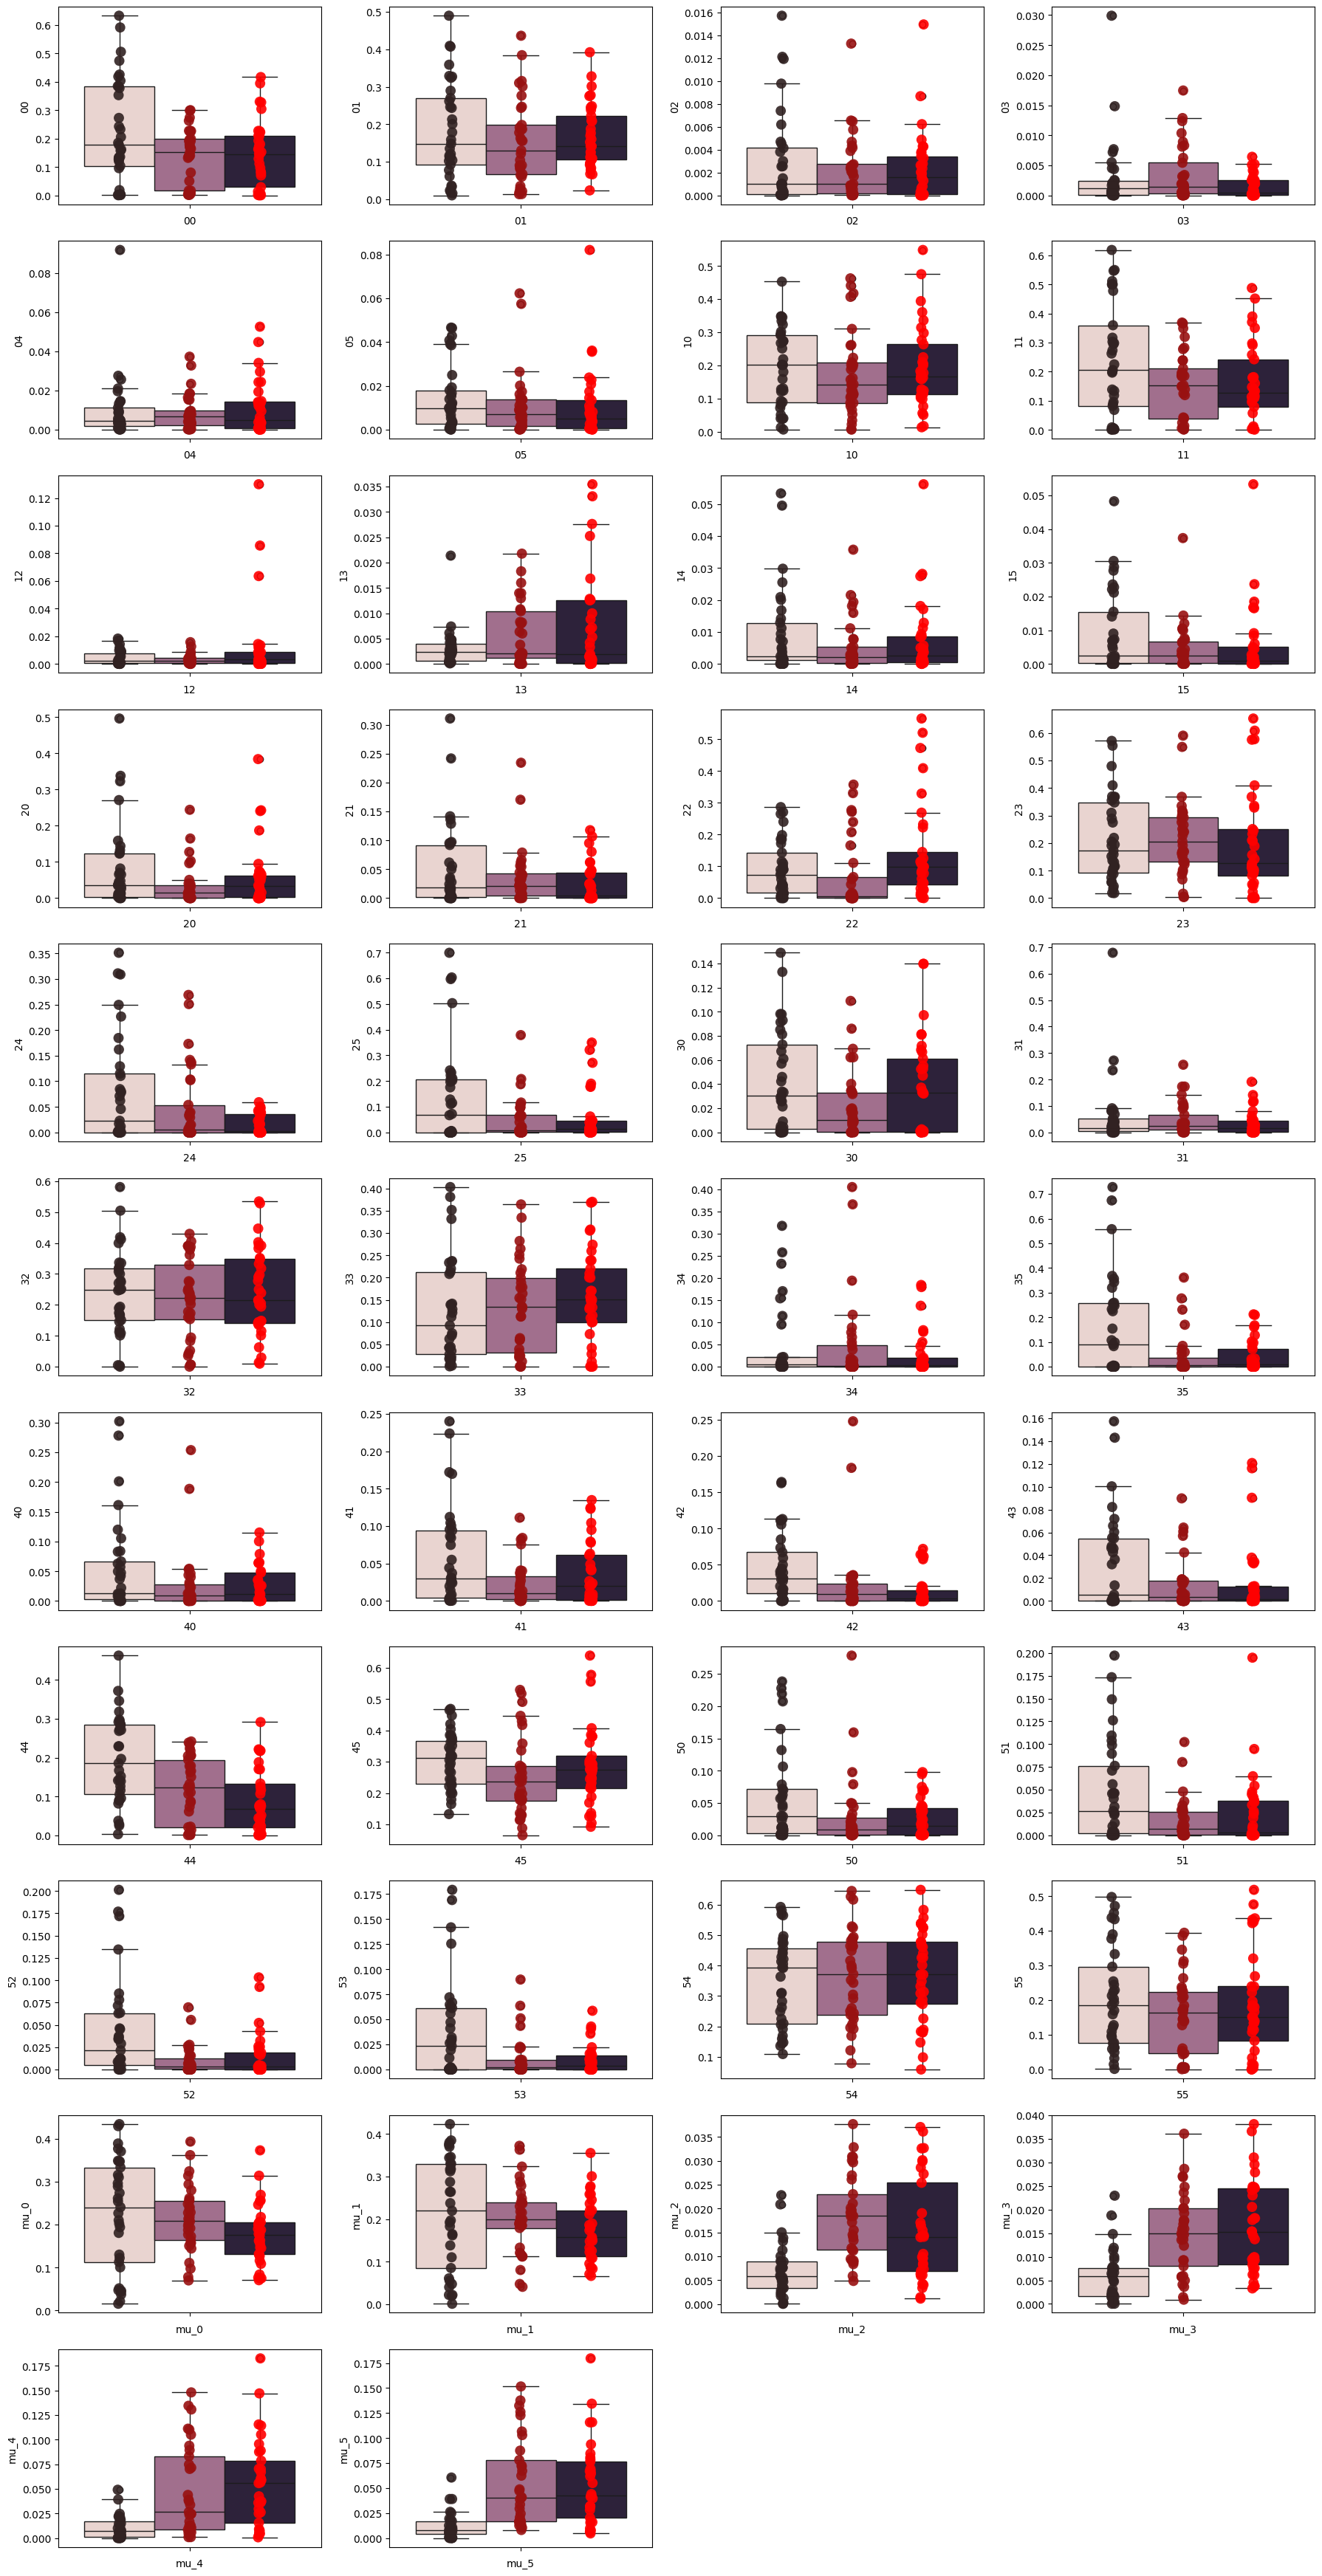

In [195]:
df = records_df

cols = df.columns[:-4]
n_cols = 4 

fig, axes = plt.subplots(nrows=len(cols) // n_cols + 1, ncols=n_cols, figsize=(18, 35))
axes = axes.flatten()

for i, feature in enumerate(cols):
    ax = axes[i]
    sns.boxplot(data=df, y=feature, hue = 'blk_hr',ax=ax)
    sns.stripplot(data=df, y=feature, ax=ax,
                hue='blk_hr', dodge=True, palette='dark:red', size=10, alpha=0.9, jitter=0.02)

    ax.set_xlabel(feature)
    ax.legend_.remove()

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Dataframe Construction

Goal: Run the hawkes system over various days and datasets, use the dataset to build the forcasting model, and the mid price prediction model

In [ ]:
root_training = "dataset_bb0_1/APPL_MIX_1s_training"

In [ ]:
daily_feature_list = []

files = os.listdir(root_training)
num_files = len(files)

for j, filename in enumerate(files):

    path = f"{root_training}/{filename}"

    # ---------------------
    # Extract YYYYMMDD from filename
    # ---------------------
    # filename example: "equs-mini-20240112.bbo-1s.csv.ztst"
    base = filename.split(".")[0]          # -> "equs-mini-20240112"
    date_token = base.split("-")[-1]       # -> "20240112"

    # ---------------------
    # Load raw data
    # ---------------------
    raw_day_df = pd.read_csv(path, compression='zstd')
        
    raw_day_df['ts_recv'] = (pd.to_datetime(raw_day_df['ts_recv'], utc=True)
        .dt.tz_convert("UTC")
        .dt.tz_convert("America/New_York"))

    # Create hawkes system
    hwk = hawkes_system()

    for i in range(0, len(raw_day_df)): 
    
        row = raw_day_df.loc[[i], : ]
        hr = pd.to_datetime(row['ts_recv']).dt.hour.values[0]
        if  (hr>=8) and (hr <=17): 
            hwk.read_pd_raw(row_curr=row)
            hwk.update_features()

    # Produce per-day features
    day_features = get_feature_frames(hwk)

    # Save per-day
    out_name = f"{date_token}.csv"
    day_features.to_csv(f"dataset_ml/training_data_raw/{out_name}")

    daily_feature_list.append(day_features)

    print(np.round((j+1)/num_files, 2))

# # Merge all days
full_training_df = pd.concat(daily_feature_list, ignore_index=True)
full_training_df.to_csv("dataset_ml/training_data_hwks_merge.csv")

0.08
0.15
0.23
0.31
0.38
0.46
0.54
0.62
0.69
0.77
0.85
0.92
1.0


## Correlation Analysis

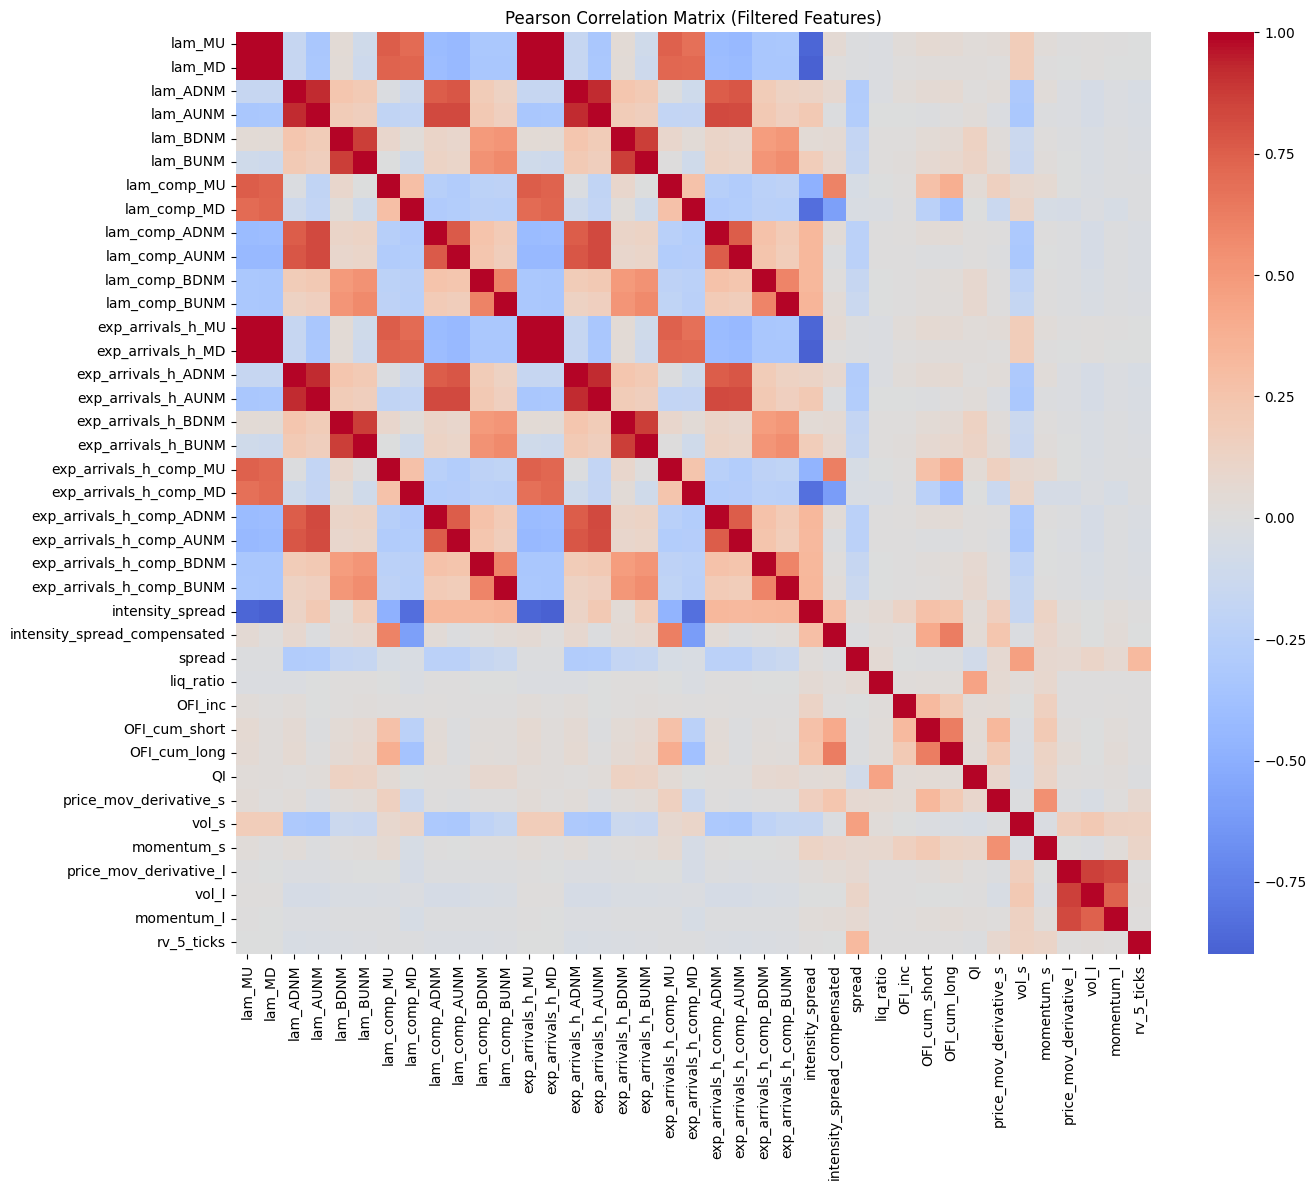

In [196]:
exclude_cols = [
    't_cur', 'c_cur',
    'mid_price', 'bid_sz', 'bid_px', 'ask_sz', 'ask_px',
    'avg_5_ticks', 'avg_10_ticks', 'log_ret',
    'time_stamp', 
    'price_off_open', 
    '5s_price_delta', '10s_price_delta'
]

# Determine usable columns
use_cols = [col for col in full_training_df.columns if col not in exclude_cols]

# Compute correlation matrix
corr_matrix = full_training_df[use_cols].corr(method='pearson')


plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Pearson Correlation Matrix (Filtered Features)")
plt.tight_layout()
plt.show()



Aligns pretty strongly with expecations, the intensity and the expected arrival are very similiar besides some small scaling

In [197]:
corr_df = correlated_pairs(corr_matrix, threshold=.8)
corr_df

feature_1                 feature_2  correlation
0                 lam_BDNM       exp_arrivals_h_BDNM     1.000000
1                   lam_MD         exp_arrivals_h_MD     1.000000
2                 lam_AUNM       exp_arrivals_h_AUNM     1.000000
3                   lam_MU         exp_arrivals_h_MU     1.000000
4                 lam_BUNM       exp_arrivals_h_BUNM     1.000000
5                 lam_ADNM       exp_arrivals_h_ADNM     1.000000
6            lam_comp_ADNM  exp_arrivals_h_comp_ADNM     0.999977
7            lam_comp_AUNM  exp_arrivals_h_comp_AUNM     0.999968
8            lam_comp_BDNM  exp_arrivals_h_comp_BDNM     0.999672
9              lam_comp_MU    exp_arrivals_h_comp_MU     0.999630
10             lam_comp_MD    exp_arrivals_h_comp_MD     0.999619
11           lam_comp_BUNM  exp_arrivals_h_comp_BUNM     0.999535
12                  lam_MU         exp_arrivals_h_MD     0.998132
13                  lam_MU                    lam_MD     0.998132
14                  lam_MD         exp_arrivals_h_MU     0.998132
15       exp_arrivals_h_MU         exp_arrivals_h_MD     0.998132
16                lam_ADNM                  lam_AUNM     0.923991
17                lam_ADNM       exp_arrivals_h_AUNM     0.923991
18                lam_AUNM       exp_arrivals_h_ADNM     0.923991
19     exp_arrivals_h_ADNM       exp_arrivals_h_AUNM     0.923991
20     exp_arrivals_h_BDNM       exp_arrivals_h_BUNM     0.870524
21                lam_BUNM       exp_arrivals_h_BDNM     0.870524
22                lam_BDNM       exp_arrivals_h_BUNM     0.870524
23                lam_BDNM                  lam_BUNM     0.870524
24  price_mov_derivative_l                     vol_l     0.861547
25                lam_AUNM             lam_comp_ADNM     0.824623
26           lam_comp_ADNM       exp_arrivals_h_AUNM     0.824623
27  price_mov_derivative_l                momentum_l     0.824234
28     exp_arrivals_h_AUNM  exp_arrivals_h_comp_ADNM     0.822885
29                lam_AUNM  exp_arrivals_h_comp_ADNM     0.822885
30                lam_AUNM             lam_comp_AUNM     0.822593
31           lam_comp_AUNM       exp_arrivals_h_AUNM     0.822593
32                lam_AUNM  exp_arrivals_h_comp_AUNM     0.820079
33     exp_arrivals_h_AUNM  exp_arrivals_h_comp_AUNM     0.820079
34  exp_arrivals_h_comp_MD          intensity_spread    -0.825609
35             lam_comp_MD          intensity_spread    -0.835522
36                  lam_MU          intensity_spread    -0.870614
37       exp_arrivals_h_MU          intensity_spread    -0.870614
38       exp_arrivals_h_MD          intensity_spread    -0.899045
39                  lam_MD          intensity_spread    -0.899045

In [198]:
# ------- Reorder, we perfer exp_arrival features more realisitically consistent
cols = corr_matrix.columns.tolist()

# Priority groups
exp_cols  = [c for c in cols if c.startswith("exp_arrivals_")]
comp_cols = [c for c in cols if "_comp" in c and c not in exp_cols]
other     = [c for c in cols if c not in exp_cols and c not in comp_cols]

new_order = exp_cols + comp_cols + other

corr_matrix = corr_matrix[new_order]

# ------ Remove highly correlated features 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [
    column for column in upper.columns
    if any(upper[column] > .8)
]
to_keep = [col for col in full_training_df.columns if col not in to_drop]


In [202]:
full_training_df[to_keep].to_csv('dataset_ml/training_data_hwks_corr.csv')

# Volatility forcasting

In [203]:
micro_feat_df  = pd.read_csv("dataset_ml/training_data_hwks_corr.csv", index_col = 0 )
micro_feat_df['time_stamp'] = pd.to_datetime(micro_feat_df['time_stamp'])

## Binning Analysis

C:\Users\isaac\AppData\Local\Temp\ipykernel_30396\2079970172.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("x_bin")["y"].mean()


Text(0, 0.5, 'mean rv_5_ticks')

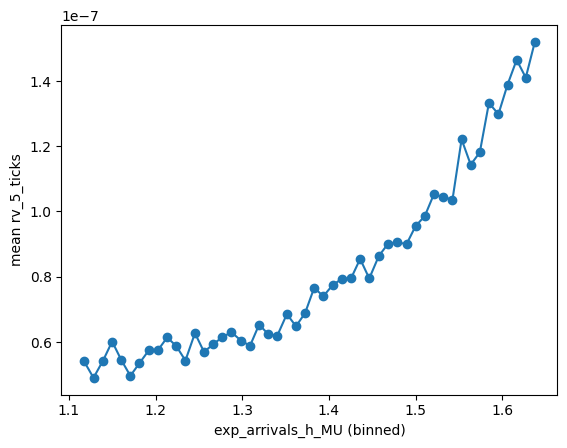

In [204]:
x = micro_feat_df['exp_arrivals_h_MU'] 
y= micro_feat_df['rv_5_ticks']

x,y = quantile_filter(x,y)
x_t, grouped = bin_by_x(x,y)

plt.plot(x_t, grouped.values, marker="o")
plt.xlabel("exp_arrivals_h_MU (binned)")
plt.ylabel("mean rv_5_ticks")


C:\Users\isaac\AppData\Local\Temp\ipykernel_30396\2079970172.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("x_bin")["y"].mean()


Text(0, 0.5, 'abs((5s_price_delta)')

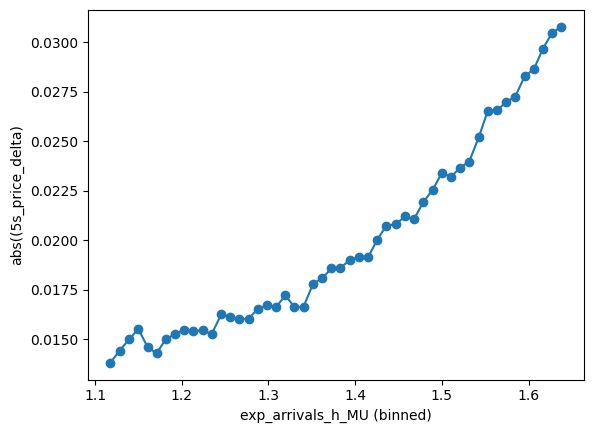

In [205]:
x = micro_feat_df['exp_arrivals_h_MU'] 
y= abs(micro_feat_df['5s_price_delta'])

x,y = quantile_filter(x,y)
x_t, grouped = bin_by_x(x,y)

plt.plot(x_t, grouped.values, marker="o")
plt.xlabel("exp_arrivals_h_MU (binned)")
plt.ylabel("abs((5s_price_delta)")


C:\Users\isaac\AppData\Local\Temp\ipykernel_30396\2079970172.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("x_bin")["y"].mean()


Text(0, 0.5, 'mean rv_5_ticks')

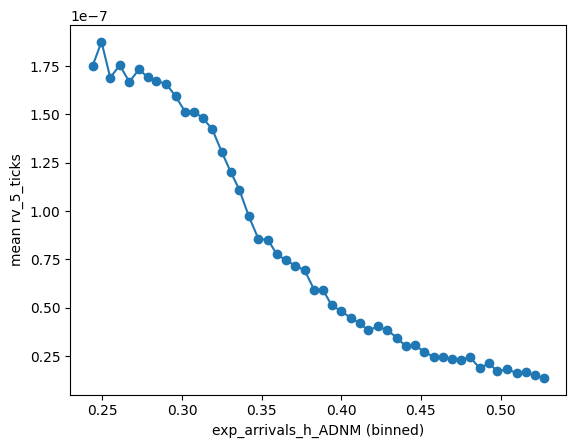

In [206]:
x = micro_feat_df['exp_arrivals_h_ADNM'] 
y= micro_feat_df['rv_5_ticks']

x,y = quantile_filter(x,y)
x_t, grouped = bin_by_x(x,y)

plt.plot(x_t, grouped.values, marker="o")
plt.xlabel("exp_arrivals_h_ADNM (binned)")
plt.ylabel("mean rv_5_ticks")


C:\Users\isaac\AppData\Local\Temp\ipykernel_30396\2079970172.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("x_bin")["y"].mean()


Text(0, 0.5, 'mean rv_5_ticks')

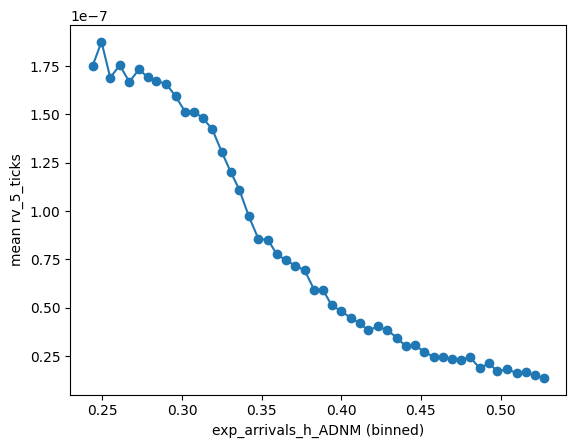

In [208]:
x = micro_feat_df['exp_arrivals_h_ADNM'] 
y= micro_feat_df['rv_5_ticks']

x,y = quantile_filter(x,y)
x_t, grouped = bin_by_x(x,y)

x_t = [i.mid for i in grouped.index]
plt.plot(x_t, grouped.values, marker="o")
plt.xlabel("exp_arrivals_h_ADNM (binned)")
plt.ylabel("mean rv_5_ticks")


## Model Training - Realized Voltality Forcasting

In [242]:
training_vol =  pd.read_csv("dataset_ml/training_data_hwks_corr.csv", index_col = 0 )

# Add some time features 
training_vol['time_stamp'] = pd.to_datetime(training_vol['time_stamp'])
training_vol['date'] = training_vol['time_stamp'].dt.date
training_vol['hour'] = training_vol['time_stamp'].dt.hour

# Predict log values, helps with stability 
training_vol['log_rv_5'] = np.log(training_vol['rv_5_ticks'] + 1e-9)

# Shuffle
training_vol= training_vol.sample(frac=1)


In [243]:
hwks_features = ['exp_arrivals_h_MU', 'exp_arrivals_h_ADNM', 'exp_arrivals_h_BDNM',
       'exp_arrivals_h_comp_MU', 'exp_arrivals_h_comp_MD',
       'exp_arrivals_h_comp_BDNM', 'exp_arrivals_h_comp_BUNM',
       'intensity_spread_compensated',]

non_hwks_features = [
    'spread', 'liq_ratio', 'OFI_inc',
    'OFI_cum_short', 'OFI_cum_long', 'QI',
    'price_mov_derivative_s', 'vol_s', 'momentum_s',
    'price_mov_derivative_l',
    
]

slim_no_hwks = ['liq_ratio', 'OFI_inc',
    'OFI_cum_short', 'OFI_cum_long', 'QI',
    'price_mov_derivative_s', 'momentum_s',
    'price_mov_derivative_l',]

feature_list_base = non_hwks_features + hwks_features
feature_list_slim = slim_no_hwks + hwks_features

target_feature = 'log_rv_5' 

Cross validation based on days

In [244]:
unique_days = np.array(sorted(training_vol['date'].unique()))
np.random.shuffle(unique_days)

# Make 5 folds across distinct days
folds = np.array_split(unique_days, 12)

### Model Definition 

In [ ]:
def create_model_vol_forcast(feature_list, target_col, fold_assignments, df):
    # Feature matrix and target
    X = df[feature_list]
    y = df[target_col]

    results = []

    for fold_idx, test_day_set in enumerate(fold_assignments):

        # Split by date (no leakage)
        train_day_set = [day for day in unique_days if day not in test_day_set]

        train_mask = df['date'].isin(train_day_set)
        test_mask  = df['date'].isin(test_day_set)

        X_train, y_train = X[train_mask].copy(), y[train_mask].copy()
        X_test,  y_test  = X[test_mask],        y[test_mask]

        # Model definition
        model = XGBRegressor(
            objective="reg:quantileerror",
            quantile_alpha=0.5,
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
        )
                
        # Fit model
        model.fit(X_train, y_train)

        # Predictions 
        y_pred = model.predict(X_test)

        # Metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test.values, y_pred)

        results.append({
            "fold": fold_idx,
            "r2": r2,
            'mse' : mse,
        })

    # Final model trained on full dataset
    final_model = (
      XGBRegressor(
            objective="reg:quantileerror",
            quantile_alpha=0.5,
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
        )
        .fit(X, y)
    )

    # Aggregate fold R² values
    res_df = pd.DataFrame(results)

    print("Average R²:",   res_df["r2"].mean(),   "Std:", res_df["r2"].std())
    print("Avg mse:",     res_df["mse"].mean(), "Std:", res_df["mse"].std())

    # Get feauture importance
    perm = permutation_importance(
        final_model,
        X,                     # full training features
        y,                     # full training target
        n_repeats=10,          # more repeats = more stable
        random_state=0,
        n_jobs=-1
    )

    # Build dataframe
    imp_df = pd.DataFrame({
        "feature": feature_list,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    }).sort_values("importance_mean", ascending=False)

    return final_model, res_df, imp_df


### Results 

Baseline model 

In [259]:
model_base, res_df, imp_df = create_model_vol_forcast(feature_list = feature_list_base, target_col=target_feature,
             fold_assignments=folds, df = training_vol)
imp_df

Average R²: 0.3151613152313012 Std: 0.10330413802655716
Avg mse: 1.9583657436658966 Std: 0.9150799089561183


feature  importance_mean  importance_std
7                          vol_s         0.295099        0.001665
0                         spread         0.095633        0.000473
15      exp_arrivals_h_comp_BDNM         0.032058        0.000462
16      exp_arrivals_h_comp_BUNM         0.009509        0.000228
9         price_mov_derivative_l         0.008906        0.000200
11           exp_arrivals_h_ADNM         0.007516        0.000162
12           exp_arrivals_h_BDNM         0.006629        0.000156
10             exp_arrivals_h_MU         0.004986        0.000122
8                     momentum_s         0.003108        0.000165
14        exp_arrivals_h_comp_MD         0.002971        0.000098
13        exp_arrivals_h_comp_MU         0.001931        0.000041
2                        OFI_inc         0.001596        0.000137
4                   OFI_cum_long         0.001498        0.000069
6         price_mov_derivative_s         0.001397        0.000033
1                      liq_ratio         0.001009        0.000047
5                             QI         0.000910        0.000043
17  intensity_spread_compensated         0.000889        0.000032
3                  OFI_cum_short         0.000804        0.000042

No hawkes model

In [247]:
model_no_hwk, res_df, imp_df = create_model_vol_forcast(feature_list = non_hwks_features, target_col=target_feature,
             fold_assignments=folds, df = training_vol)
imp_df

Average R²: 0.2904393560570588 Std: 0.0882090538992668
Avg mse: 2.0079628205154374 Std: 0.8754002503681428


feature  importance_mean  importance_std
7                   vol_s         0.292975        0.001761
0                  spread         0.122087        0.000528
9  price_mov_derivative_l         0.035433        0.000380
6  price_mov_derivative_s         0.007541        0.000258
8              momentum_s         0.007313        0.000164
4            OFI_cum_long         0.007069        0.000186
2                 OFI_inc         0.004735        0.000152
1               liq_ratio         0.003071        0.000059
3           OFI_cum_short         0.002494        0.000082
5                      QI         0.002346        0.000037

Slim features

In [248]:
model_slim, res_df, imp_df = create_model_vol_forcast(feature_list = feature_list_slim, target_col=target_feature,
             fold_assignments=folds, df = training_vol)
imp_df

Average R²: 0.22609578606892497 Std: 0.14743024429364163
Avg mse: 2.2303746200140706 Std: 1.122225128732641


feature  importance_mean  importance_std
6                     momentum_s         0.123890        0.000901
5         price_mov_derivative_s         0.073485        0.001037
9            exp_arrivals_h_ADNM         0.068979        0.000913
13      exp_arrivals_h_comp_BDNM         0.067335        0.000411
7         price_mov_derivative_l         0.049127        0.000563
8              exp_arrivals_h_MU         0.021194        0.000303
2                  OFI_cum_short         0.012885        0.000172
14      exp_arrivals_h_comp_BUNM         0.010850        0.000283
3                   OFI_cum_long         0.007787        0.000148
11        exp_arrivals_h_comp_MU         0.007131        0.000179
10           exp_arrivals_h_BDNM         0.006486        0.000147
1                        OFI_inc         0.006324        0.000186
0                      liq_ratio         0.005266        0.000123
12        exp_arrivals_h_comp_MD         0.005065        0.000103
4                             QI         0.001955        0.000039
15  intensity_spread_compensated         0.001904        0.000080

### Model Exports 

In [ ]:
features_final = feature_list_base

model_q80 = XGBRegressor(
    objective="reg:quantileerror",
    quantile_alpha=0.8,      
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
)

model_q20 = XGBRegressor(
    objective="reg:quantileerror",
    quantile_alpha=0.2,
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
)

model_q50 = XGBRegressor(
    objective="reg:quantileerror",
    quantile_alpha=0.5,
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
)
model_q80.fit(training_vol[features_final], training_vol[target_feature])
model_q20.fit(training_vol[features_final], training_vol[target_feature])
model_q50.fit(training_vol[features_final], training_vol[target_feature])

joblib.dump(model_q20, "models/xgb_quantile_20.pkl")
joblib.dump(model_q50, "models/xgb_quantile_50.pkl")
joblib.dump(model_q80, "models/xgb_quantile_80.pkl")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

# Model Training - Mid Price

In [275]:
# Load your merged training df
full_training_df = pd.read_csv("dataset_ml/training_data_hwks_corr.csv", index_col=0)

# Add some time features 
full_training_df['time_stamp'] = pd.to_datetime(full_training_df['time_stamp'])
full_training_df['date'] = full_training_df['time_stamp'].dt.date
full_training_df['hour'] = full_training_df['time_stamp'].dt.hour

# Drop leakage columns
leak_cols = ["avg_5_ticks", "avg_10_ticks", "10s_price_delta", "rv_5_ticks"]
full_training_df = full_training_df.drop(columns=leak_cols, errors="ignore")

# setup dir 
dir_indicator = "5s_price_delta"
full_training_df = make_dir_labels(full_training_df, epsilon=0.015)

# Check on class imbalance
full_training_df['dir'].value_counts()

dir
 0    97297
 1    46102
-1    45047
Name: count, dtype: int64

In [276]:
unique_days = np.array(sorted(full_training_df['date'].unique()))
np.random.shuffle(unique_days)

# Make 5 folds across distinct days
folds = np.array_split(unique_days, len(unique_days) // 2)

In [310]:
# Training for volatility, only want to predict a price jump or no price jump
training_vol = full_training_df.copy()
training_vol.loc[training_vol['dir'] == -1, 'dir'] = 1 

# Traing for direction prediction: only predict direction if there is a jump 
training_dir = full_training_df.copy()
training_dir = training_dir.loc[training_dir['dir'] != 0 , :] 
training_dir.loc[training_dir['dir'] == -1, "dir"] = 0 

In [ ]:
hwks_features = ['exp_arrivals_h_MU', 'exp_arrivals_h_ADNM', 'exp_arrivals_h_BDNM',
       'exp_arrivals_h_comp_MU', 'exp_arrivals_h_comp_MD',
       'exp_arrivals_h_comp_BDNM', 'exp_arrivals_h_comp_BUNM',
       'intensity_spread_compensated',]

non_hwks_features = [
    'spread', 'liq_ratio', 'OFI_inc',
    'OFI_cum_short', 'OFI_cum_long', 'QI',
    'price_mov_derivative_s', 'vol_s', 'momentum_s',
    'price_mov_derivative_l',    
]

feature_list_base = non_hwks_features + hwks_features

target_col = 'dir'


### Model Definition 

In [ ]:
def create_model_class(feature_list, target_col, fold_assignments, df, conf_threshold=0.7):
    """
    Train an XGB classifier with day-based CV.
    Returns:
        final_model: fitted on full data
        res_df: per-fold metrics (accuracy, F1, per-class accuracy, confident-accuracy)
        imp_df: permutation feature importance on full data
    """
    # Feature matrix and target
    X = df[feature_list]
    y = df[target_col]

    results = []

    for fold_idx, test_day_set in enumerate(fold_assignments):

        # Split by date (no leakage)
        train_day_set = [day for day in unique_days if day not in test_day_set]

        train_mask = df['date'].isin(train_day_set)
        test_mask  = df['date'].isin(test_day_set)

        df_train = df[train_mask].copy()
        df_test  = df[test_mask].copy()
        
        # apply undersampling only to the training set
        df_train = quick_under_sample(df_train)

        X_train, y_train = df_train[feature_list].copy(), df_train[target_col].copy()
        X_test,  y_test  = df_test[feature_list].copy(),  df_test[target_col].copy()


        # Model definition (let XGB pick appropriate objective)
        model = XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            random_state=0,
        )

        # Fit model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        probs  = model.predict_proba(X_test)  # for confidence threshold

        # Overall metrics
        acc_overall   = accuracy_score(y_test, y_pred)
        f1_macro      = f1_score(y_test, y_pred, average="macro")
        f1_weighted   = f1_score(y_test, y_pred, average="weighted")

        # Per-class accuracy (essentially recall per class)
        per_class_acc = {}
        for cls in model.classes_:
            mask_c = (y_test == cls)
            if mask_c.sum() > 0:
                per_class_acc[cls] = accuracy_score(y_test[mask_c], y_pred[mask_c])
            else:
                per_class_acc[cls] = np.nan

        # Accuracy only on "confident" predictions
        max_prob = probs.max(axis=1)
        conf_mask = max_prob >= conf_threshold

        if conf_mask.sum() > 0:
            acc_confident = accuracy_score(y_test[conf_mask], y_pred[conf_mask])
            coverage_conf = conf_mask.mean()  # fraction of test points where model is "confident"
        else:
            acc_confident = np.nan
            coverage_conf = 0.0

        results.append({
            "fold": fold_idx,
            "accuracy": acc_overall,
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "per_class_accuracy": per_class_acc,
            "acc_confident": acc_confident,
            "coverage_confident": coverage_conf,
        })

    # Final model trained on full dataset
    final_model = (
        XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            random_state=0,
        )
        .fit(X, y)
    )

    # Aggregate fold metrics
    res_df = pd.DataFrame(results)

    print("Average accuracy:",  res_df["accuracy"].mean(),   "Std:", res_df["accuracy"].std())
    print("Average F1 (macro):", res_df["f1_macro"].mean(),  "Std:", res_df["f1_macro"].std())
    print("Average F1 (weighted):", res_df["f1_weighted"].mean(), "Std:", res_df["f1_weighted"].std())
    print("Avg confident accuracy:", res_df["acc_confident"].mean(), "Std:", res_df["acc_confident"].std())
    print("Avg confident coverage:", res_df["coverage_confident"].mean())

    # Permutation feature importance on full data (by default uses .score = accuracy)
    perm = permutation_importance(
        final_model,
        X,
        y,
        n_repeats=10,
        random_state=0,
        n_jobs=-1
    )

    imp_df = pd.DataFrame({
        "feature": feature_list,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    }).sort_values("importance_mean", ascending=False)

    return final_model, res_df, imp_df


### Results: Price Jumps

In [286]:
final_model, res_df, imp_df = create_model_class(feature_list = feature_list_base, 
                   target_col = target_col, 
                   fold_assignments = folds, 
                   df = training_vol, conf_threshold=0.6)

Average accuracy: 0.6864114865930163 Std: 0.03879715196210473
Average F1 (macro): 0.6815882776192187 Std: 0.03446447654801336
Average F1 (weighted): 0.6849031117356527 Std: 0.03750948419479961
Avg confident accuracy: 0.7371458029617091 Std: 0.03584967415515189
Avg confident coverage: 0.7264760942973508


In [287]:
final_model, res_df, imp_df = create_model_class(feature_list = hwks_features, 
                   target_col = target_col, 
                   fold_assignments = folds, 
                   df = training_vol, conf_threshold=0.6)
imp_df

Average accuracy: 0.6463168080253705 Std: 0.03467672241209902
Average F1 (macro): 0.6404626510757003 Std: 0.03127539870077006
Average F1 (weighted): 0.6436748798013253 Std: 0.03443492313847673
Avg confident accuracy: 0.6985477582789189 Std: 0.04562478008755268
Avg confident coverage: 0.6412519786814078


feature  importance_mean  importance_std
1           exp_arrivals_h_ADNM         0.066148        0.000666
5      exp_arrivals_h_comp_BDNM         0.028866        0.000738
0             exp_arrivals_h_MU         0.015291        0.000452
6      exp_arrivals_h_comp_BUNM         0.007858        0.000507
2           exp_arrivals_h_BDNM         0.006272        0.000501
4        exp_arrivals_h_comp_MD         0.002330        0.000270
7  intensity_spread_compensated         0.001425        0.000241
3        exp_arrivals_h_comp_MU         0.001232        0.000241

In [291]:
final_model, res_df, imp_df = create_model_class(feature_list = non_hwks_features, 
                   target_col = target_col, 
                   fold_assignments = folds, 
                   df = training_vol, conf_threshold=0.6)
imp_df

Average accuracy: 0.683446835254276 Std: 0.04105142263479732
Average F1 (macro): 0.6789589511645877 Std: 0.03740751912123061
Average F1 (weighted): 0.6822168042259614 Std: 0.04007629925667881
Avg confident accuracy: 0.7284037670641615 Std: 0.03818946241037957
Avg confident coverage: 0.7354141504804862


feature  importance_mean  importance_std
7                   vol_s         0.063723        0.000629
0                  spread         0.026221        0.000371
9  price_mov_derivative_l         0.012397        0.000399
4            OFI_cum_long         0.002408        0.000185
6  price_mov_derivative_s         0.002140        0.000191
2                 OFI_inc         0.001892        0.000184
8              momentum_s         0.001597        0.000240
3           OFI_cum_short         0.000881        0.000198
1               liq_ratio         0.000426        0.000143
5                      QI         0.000188        0.000104

### Result: Price Direction 

In [313]:
final_model, res_df, imp_df = create_model_class(feature_list = feature_list_base, 
                   target_col = target_col, 
                   fold_assignments = folds, 
                   df = training_dir, conf_threshold=0.6)
imp_df

Average accuracy: 0.6226307149139344 Std: 0.04457674492515721
Average F1 (macro): 0.62246357610121 Std: 0.04466800620279318
Average F1 (weighted): 0.6223511859748584 Std: 0.04475083874417208
Avg confident accuracy: 0.7416971208555777 Std: 0.06337545399962691
Avg confident coverage: 0.3978764791963118


feature  importance_mean  importance_std
8                     momentum_s         0.036780        0.001315
0                         spread         0.036424        0.000979
1                      liq_ratio         0.021897        0.000648
2                        OFI_inc         0.017031        0.000978
16      exp_arrivals_h_comp_BUNM         0.008617        0.000683
7                          vol_s         0.007532        0.000692
15      exp_arrivals_h_comp_BDNM         0.007252        0.000469
12           exp_arrivals_h_BDNM         0.006058        0.000627
9         price_mov_derivative_l         0.005144        0.000370
13        exp_arrivals_h_comp_MU         0.005016        0.000387
17  intensity_spread_compensated         0.004628        0.000386
4                   OFI_cum_long         0.004551        0.000377
11           exp_arrivals_h_ADNM         0.004361        0.000435
10             exp_arrivals_h_MU         0.003707        0.000511
14        exp_arrivals_h_comp_MD         0.003528        0.000366
6         price_mov_derivative_s         0.002590        0.000522
3                  OFI_cum_short         0.002223        0.000260
5                             QI         0.000262        0.000767

In [314]:
final_model, res_df, imp_df = create_model_class(feature_list = non_hwks_features, 
                   target_col = target_col, 
                   fold_assignments = folds, 
                   df = training_dir, conf_threshold=0.6)
imp_df

Average accuracy: 0.6223622490679791 Std: 0.043462624862569806
Average F1 (macro): 0.6222049688486515 Std: 0.04353128637884805
Average F1 (weighted): 0.6221198720012351 Std: 0.04363932997586896
Avg confident accuracy: 0.7392289055263946 Std: 0.07248222825770853
Avg confident coverage: 0.39004311328113866


feature  importance_mean  importance_std
0                  spread         0.038015        0.000816
8              momentum_s         0.032458        0.000639
1               liq_ratio         0.020874        0.000940
2                 OFI_inc         0.020185        0.001194
7                   vol_s         0.008450        0.000766
9  price_mov_derivative_l         0.006961        0.000569
4            OFI_cum_long         0.006395        0.000520
6  price_mov_derivative_s         0.005601        0.000518
5                      QI         0.004065        0.000844
3           OFI_cum_short         0.003322        0.000318

In [315]:
final_model, res_df, imp_df = create_model_class(feature_list = hwks_features, 
                   target_col = target_col, 
                   fold_assignments = folds, 
                   df = training_dir, conf_threshold=0.6)
imp_df

Average accuracy: 0.5126763261982061 Std: 0.006579085733812252
Average F1 (macro): 0.5101709070534381 Std: 0.008390305181359088
Average F1 (weighted): 0.5099035795659858 Std: 0.009156093234572858
Avg confident accuracy: 0.5470781286259777 Std: 0.01741521433912519
Avg confident coverage: 0.04632904089539288


feature  importance_mean  importance_std
0             exp_arrivals_h_MU         0.047144        0.001115
1           exp_arrivals_h_ADNM         0.037673        0.001155
2           exp_arrivals_h_BDNM         0.035577        0.000923
6      exp_arrivals_h_comp_BUNM         0.028983        0.000868
3        exp_arrivals_h_comp_MU         0.028698        0.001273
5      exp_arrivals_h_comp_BDNM         0.025873        0.001415
4        exp_arrivals_h_comp_MD         0.022234        0.001162
7  intensity_spread_compensated         0.020761        0.000765

### Model Exports 

In [317]:
price_jump_mdl = XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            random_state=0,
        ).fit(training_vol[hwks_features], training_vol[target_col])

price_dir_mdl = XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            random_state=0,
        ).fit(training_dir[non_hwks_features], training_dir[target_col])

joblib.dump(price_jump_mdl, "models/price_jump.pkl")
joblib.dump(price_dir_mdl, "models/price_dir.pkl")

['models/price_dir.pkl']

# Additional Plots and Visualizations

In [45]:
with open('models/price_dir.pkl', "rb") as f: 
    price_dir_mdl = joblib.load(f)

with open('models/price_jump.pkl', "rb") as f: 
    price_jump_mdl = joblib.load(f)

with open('models/xgb_quantile_20.pkl', "rb") as f: 
    rv_forcast_20_mdl = joblib.load(f)

with open('models/xgb_quantile_80.pkl', "rb") as f: 
    rv_forcast_80_mdl = joblib.load(f)

with open('models/xgb_quantile_50.pkl', "rb") as f: 
    rv_forcast_50_mdl = joblib.load(f)

In [ ]:
path = "dataset_bb0_1/AAPL_1_2024/equs-mini-20240102.bbo-1s.csv.zst"

raw_day_df = pd.read_csv(path, compression='zstd')

raw_day_df['ts_recv'] = (pd.to_datetime(raw_day_df['ts_recv'], utc=True)
      .dt.tz_convert("UTC")
      .dt.tz_convert("America/New_York"))

# Create hawkes system
hwk = hawkes_system()

for i in range(0, len(raw_day_df)): 

    row = raw_day_df.loc[[i], : ]
    hr = pd.to_datetime(row['ts_recv']).dt.hour.values[0]
    if  (hr>=8) and (hr <=17): 
        hwk.read_pd_raw(row_curr=row)
        hwk.update_features()

# Produce per-day features
day_features = get_feature_frames(hwk)
day_features = make_dir_labels(day_features, epsilon=0.015)

C:\Users\isaac\AppData\Local\Temp\ipykernel_14564\1131511151.py:134: UserWarning: no explicit representation of timezones available for np.datetime64
  dt_seconds = np.datetime64(row_curr_temp[0], 's')
C:\Users\isaac\AppData\Local\Temp\ipykernel_14564\1131511151.py:134: UserWarning: no explicit representation of timezones available for np.datetime64
  dt_seconds = np.datetime64(row_curr_temp[0], 's')
C:\Users\isaac\AppData\Local\Temp\ipykernel_14564\1131511151.py:134: UserWarning: no explicit representation of timezones available for np.datetime64
  dt_seconds = np.datetime64(row_curr_temp[0], 's')
C:\Users\isaac\AppData\Local\Temp\ipykernel_14564\1131511151.py:134: UserWarning: no explicit representation of timezones available for np.datetime64
  dt_seconds = np.datetime64(row_curr_temp[0], 's')
C:\Users\isaac\AppData\Local\Temp\ipykernel_14564\1131511151.py:134: UserWarning: no explicit representation of timezones available for np.datetime64
  dt_seconds = np.datetime64(row_curr_temp

In [ ]:
output_features = day_features.copy()
output_features['time_stamp'] = (pd.to_datetime(output_features['time_stamp'], utc=True)
      .dt.tz_convert("UTC")
      .dt.tz_convert("America/New_York"))

time_mask = (output_features['time_stamp'].dt.hour >= 9 ) & (output_features['time_stamp'].dt.hour < 16 )
# low, high = output_features["rv_5_ticks"].quantile([0.05, 0.95])
# output_features = output_features[output_features["rv_5_ticks"].between(low, high)].copy()
output_features = output_features[time_mask]

output_features['jump_prop'] = predict_helper(output_features, price_jump_mdl)[: , 1]
output_features['up_dir_prop'] = predict_helper(output_features, price_dir_mdl)[: , 1]

output_features['rv_50_forcast'] = np.exp(predict_helper(output_features, rv_forcast_50_mdl, classif = False))
output_features['rv_20_forcast'] = np.exp(predict_helper(output_features, rv_forcast_20_mdl, classif = False))
output_features['rv_80_forcast'] = np.exp(predict_helper(output_features, rv_forcast_80_mdl, classif = False))

In [167]:
jump_prop_thresh = .55 
up_dir_thresh =  .6

In [ ]:
# Predict output direction 
up_dir_mask = ((output_features['jump_prop'] > jump_prop_thresh) & 
 (output_features['up_dir_prop'] > up_dir_thresh))

down_dir_mask = ((output_features['jump_prop'] > jump_prop_thresh) & 
 (output_features['up_dir_prop'] < (1- up_dir_thresh)))

static_mask = output_features['jump_prop'] < jump_prop_thresh

unknown_mask = (~up_dir_mask & ~down_dir_mask & ~static_mask)

# Create a new feature  
output_features.loc[up_dir_mask, 'dir_pred'] = 1
output_features.loc[down_dir_mask, 'dir_pred'] = -1
output_features.loc[static_mask, 'dir_pred'] = 0
output_features.loc[unknown_mask, 'dir_pred'] = -10

##  Plots

### Forcast Volatility

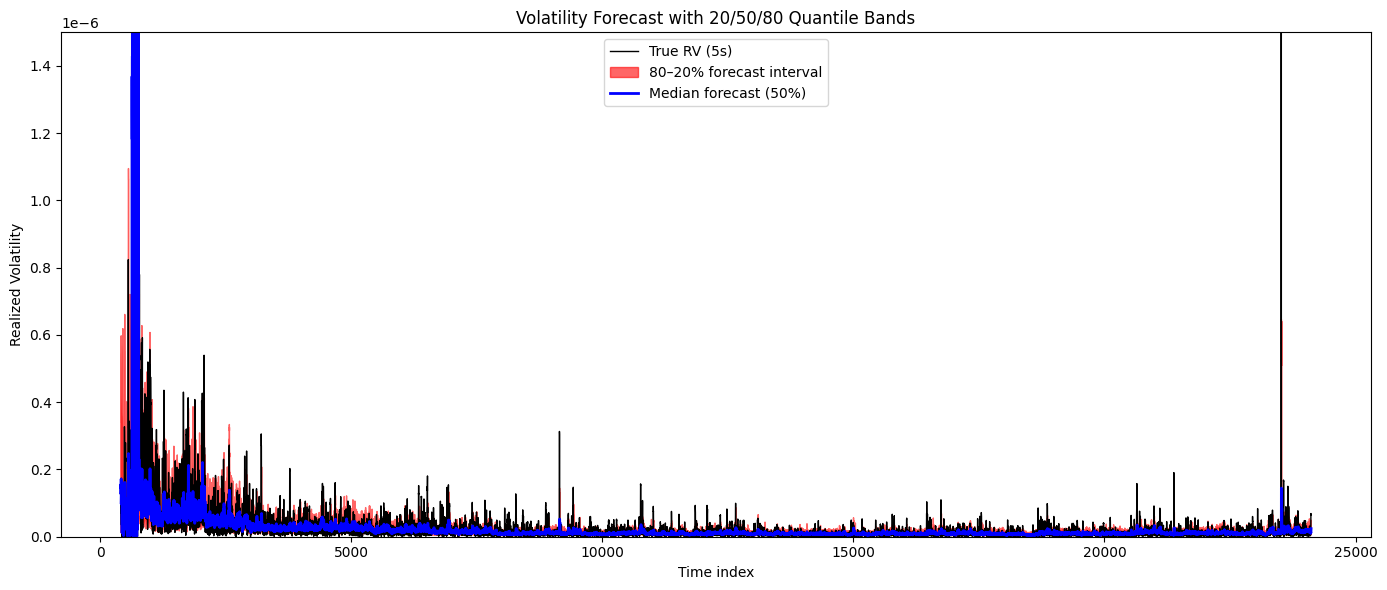

In [ ]:
df_plot = output_features.copy()

plt.figure(figsize=(14,6))

# --- 80/20 quantile band ---
# --- True realized volatility ---
plt.plot(
    df_plot.index,
    df_plot["rv_5_ticks"],
    color="black",
    linewidth=1,
    label="True RV (5s)"
)

plt.fill_between(
    df_plot.index,
    df_plot["rv_20_forcast"],
    df_plot["rv_80_forcast"],
    color="red",
    alpha=0.6,
    label="80–20% forecast interval"
)

# --- Median forecast ---
plt.plot(
    df_plot.index,
    df_plot["rv_50_forcast"],
    color="blue",
    linewidth=2,
    label="Median forecast (50%)"
)

plt.title("Volatility Forecast with 20/50/80 Quantile Bands")
plt.xlabel("Time index")
plt.ylabel("Realized Volatility")
plt.legend()
plt.tight_layout()
plt.ylim(0, .0000015)
plt.show()


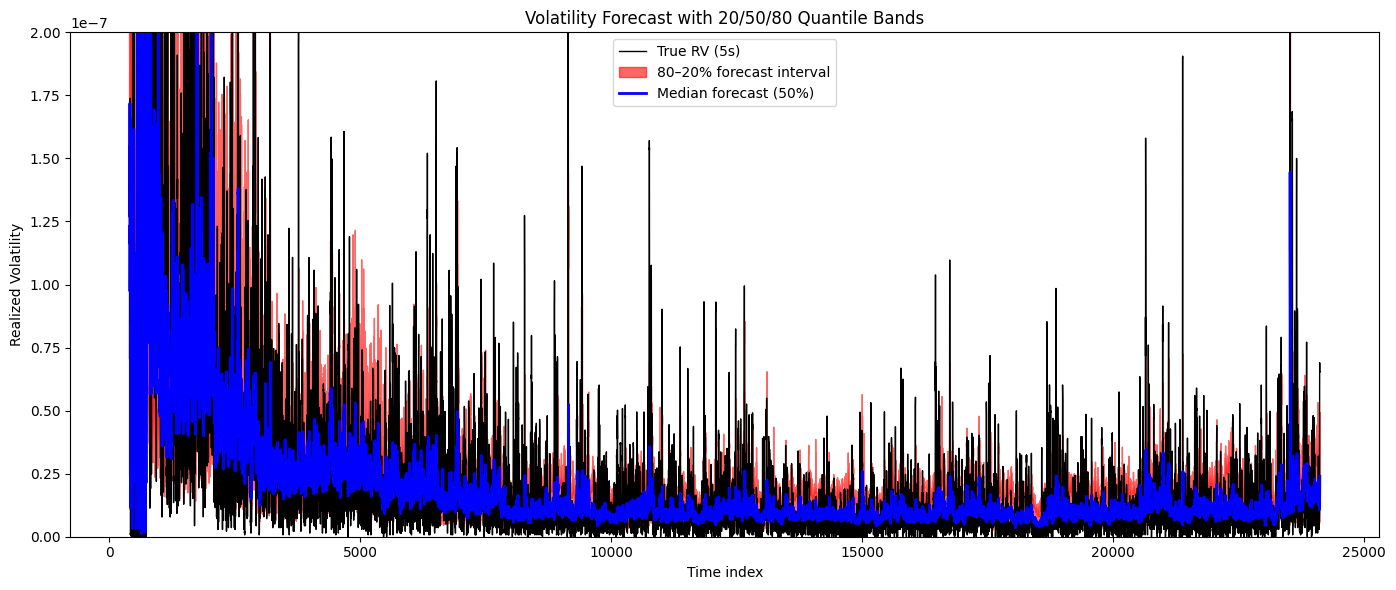

In [131]:
df_plot = output_features.copy()

plt.figure(figsize=(14,6))

# --- 80/20 quantile band ---
# --- True realized volatility ---
plt.plot(
    df_plot.index,
    df_plot["rv_5_ticks"],
    color="black",
    linewidth=1,
    label="True RV (5s)"
)

plt.fill_between(
    df_plot.index,
    df_plot["rv_20_forcast"],
    df_plot["rv_80_forcast"],
    color="red",
    alpha=0.6,
    label="80–20% forecast interval"
)

# --- Median forecast ---
plt.plot(
    df_plot.index,
    df_plot["rv_50_forcast"],
    color="blue",
    linewidth=2,
    label="Median forecast (50%)"
)

plt.title("Volatility Forecast with 20/50/80 Quantile Bands")
plt.xlabel("Time index")
plt.ylabel("Realized Volatility")
plt.legend()
plt.tight_layout()
plt.ylim(0, .0000002)
plt.show()


### Intensities Plot

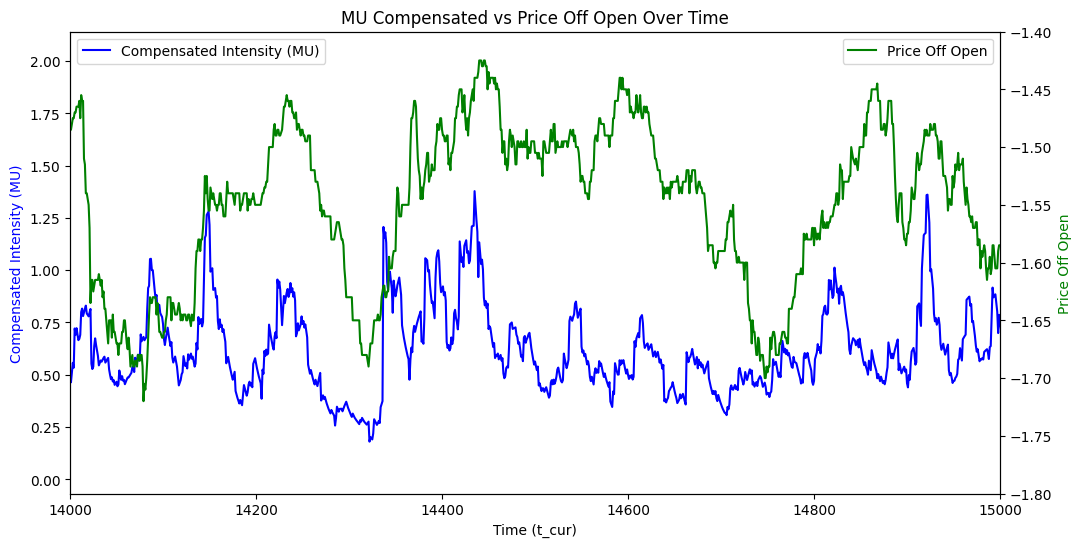

In [194]:
# Initialize the figure and the first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first line (lam_comp_MU) on the primary y-axis
sns.lineplot(x='t_cur', y='lam_comp_MU', 
             data=output_features, ax=ax1, color='blue',
               label='Compensated Intensity (MU)')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second line (mid_price) on the secondary y-axis
sns.lineplot(x='t_cur', y='price_off_open', 
             data=output_features, ax=ax2, color='green', label='Price Off Open')

# Set labels
ax1.set_ylabel('Compensated Intensity (MU)', color='blue')
ax2.set_ylabel('Price Off Open', color='green')
ax1.set_xlabel('Time (t_cur)')

# Optionally add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust limits  
ax2.set_ylim(-1.8,-1.4)
plt.xlim(14000, 15000)

# Show the plot
plt.title('MU Compensated vs Price Off Open Over Time')
plt.show()

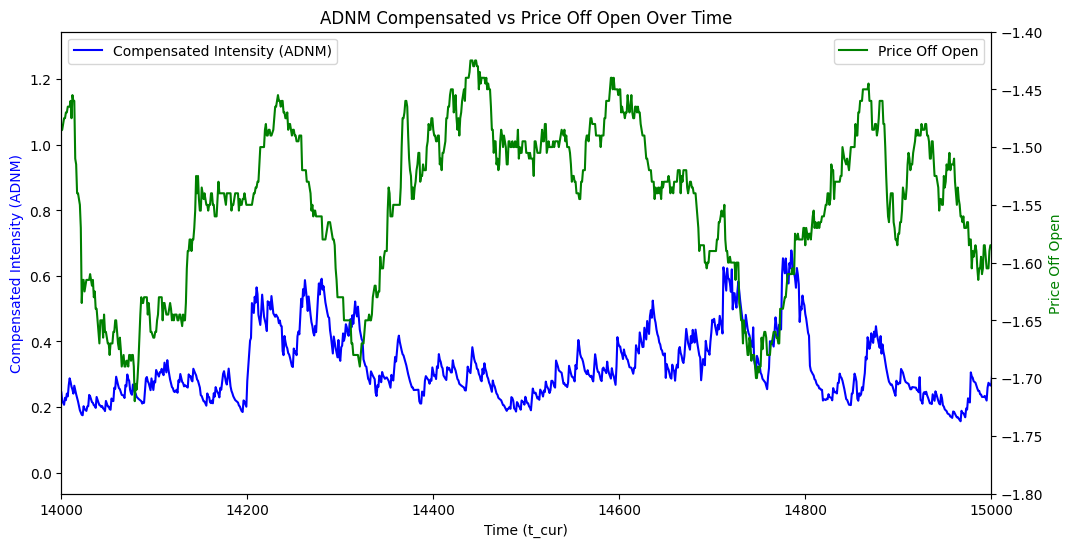

In [ ]:
# Initialize the figure and the first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first line (lam_comp_MU) on the primary y-axis
sns.lineplot(x='t_cur', y='lam_comp_ADNM', 
             data=output_features, ax=ax1, color='blue', 
             label='Compensated Intensity (ADNM)')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second line (mid_price) on the secondary y-axis
sns.lineplot(x='t_cur', y='price_off_open', 
             data=output_features, ax=ax2, color='green', label='Price Off Open')

# Set labels
ax1.set_ylabel('Compensated Intensity (ADNM)', color='blue')
ax2.set_ylabel('Price Off Open', color='green')
ax1.set_xlabel('Time (t_cur)')

# Optionally add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust limits  
ax2.set_ylim(-1.8,-1.4)
plt.xlim(14000, 15000)

# Show the plot
plt.title('ADNM Compensated vs Price Off Open Over Time')
plt.show()

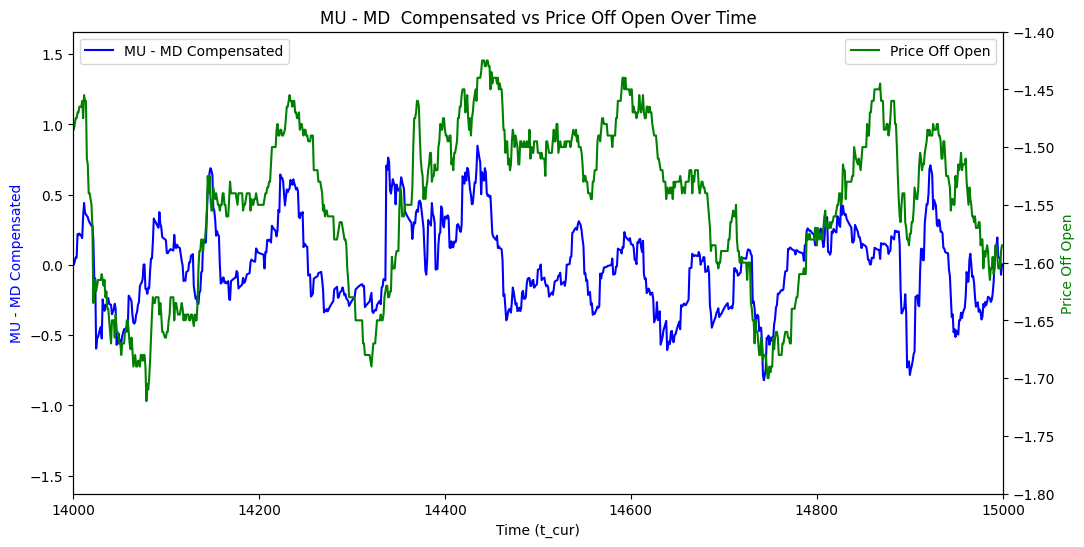

In [197]:
# Initialize the figure and the first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first line (lam_comp_MU) on the primary y-axis
sns.lineplot(x='t_cur', y='intensity_spread_compensated', 
             data=output_features, ax=ax1, color='blue', 
             label='MU - MD Compensated')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second line (mid_price) on the secondary y-axis
sns.lineplot(x='t_cur', y='price_off_open', 
             data=output_features, ax=ax2, color='green', label='Price Off Open')

# Set labels
ax1.set_ylabel('MU - MD Compensated', color='blue')
ax2.set_ylabel('Price Off Open', color='green')
ax1.set_xlabel('Time (t_cur)')

# Optionally add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust limits  
ax2.set_ylim(-1.8,-1.4)
plt.xlim(14000, 15000)

# Show the plot
plt.title('MU - MD  Compensated vs Price Off Open Over Time')
plt.show()

## Price Direction Forcasting 

In [ ]:
output_features_conf = output_features[output_features['dir_pred'] != -10]
pred_acc = (output_features_conf['dir'] == output_features_conf['dir_pred'] ).sum() / len(output_features_conf)
pred_acc

np.float64(0.7180576338272916)

# Output Dataset Creation

In [198]:
with open('models/price_dir.pkl', "rb") as f: 
    price_dir_mdl = joblib.load(f)

with open('models/price_jump.pkl', "rb") as f: 
    price_jump_mdl = joblib.load(f)

with open('models/xgb_quantile_20.pkl', "rb") as f: 
    rv_forcast_20_mdl = joblib.load(f)

with open('models/xgb_quantile_80.pkl', "rb") as f: 
    rv_forcast_80_mdl = joblib.load(f)

with open('models/xgb_quantile_50.pkl', "rb") as f: 
    rv_forcast_50_mdl = joblib.load(f)

In [199]:
jump_prop_thresh = .55 
up_dir_thresh =  .6

In [ ]:
root_training = "dataset_bb0_1/AAPL_1_2024/"

files = os.listdir(root_training)
num_files = len(files)

for j, filename in enumerate(files):

    path = f"{root_training}/{filename}"

    base = filename.split(".")[0]          # -> "equs-mini-20240112"
    date_token = base.split("-")[-1]       # -> "20240112"

    # Read the dataframe 
    raw_day_df = pd.read_csv(path, compression='zstd')

    # Adjust time zone 
    raw_day_df['ts_recv'] = (pd.to_datetime(raw_day_df['ts_recv'], utc=True)
        .dt.tz_convert("UTC")
        .dt.tz_convert("America/New_York"))

    # Create hawkes system
    hwk = hawkes_system()

    for i in range(0, len(raw_day_df)): 
        row = raw_day_df.loc[[i], : ]
        hr = pd.to_datetime(row['ts_recv']).dt.hour.values[0]
        if  (hr>=8) and (hr <=17): 
            hwk.read_pd_raw(row_curr=row)
            hwk.update_features()

    # Produce per-day features
    day_features = get_feature_frames(hwk)
    day_features = make_dir_labels(day_features, epsilon=0.015)

    # Make a copy 
    output_features = day_features.copy()

    # adjust time stamp
    output_features['time_stamp'] = (pd.to_datetime(output_features['time_stamp'], utc=True)
        .dt.tz_convert("UTC")
        .dt.tz_convert("America/New_York"))

    # Make Predictions
    output_features['jump_prop'] = predict_helper(output_features, price_jump_mdl)[: , 1]
    output_features['up_dir_prop'] = predict_helper(output_features, price_dir_mdl)[: , 1]

    output_features['rv_50_forcast'] = np.exp(predict_helper(output_features, rv_forcast_50_mdl, classif = False))
    output_features['rv_20_forcast'] = np.exp(predict_helper(output_features, rv_forcast_20_mdl, classif = False))
    output_features['rv_80_forcast'] = np.exp(predict_helper(output_features, rv_forcast_80_mdl, classif = False))

    # Predict output direction 
    up_dir_mask = ((output_features['jump_prop'] > jump_prop_thresh) & 
    (output_features['up_dir_prop'] > up_dir_thresh))

    down_dir_mask = ((output_features['jump_prop'] > jump_prop_thresh) & 
    (output_features['up_dir_prop'] < (1- up_dir_thresh)))

    static_mask = output_features['jump_prop'] < jump_prop_thresh

    unknown_mask = (~up_dir_mask & ~down_dir_mask & ~static_mask)

    # Create a new feature  
    output_features.loc[up_dir_mask, 'dir_pred'] = 1
    output_features.loc[down_dir_mask, 'dir_pred'] = -1
    output_features.loc[static_mask, 'dir_pred'] = 0
    output_features.loc[unknown_mask, 'dir_pred'] = -10

    # Save per-day
    out_name = f"{date_token}.csv"
    output_features.to_csv(f"dataset_output/{out_name}")